<a href="https://colab.research.google.com/github/kishore-n-george/telecom-churn/blob/main/telecom_churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Telecom Churn
## Objectives
The main goal of the case study is to build ML models to predict churn. The predictive model that you’re going to build will the following purposes:

It will be used to predict whether a high-value customer will churn or not, in near future (i.e. churn phase). By knowing this, the company can take action steps such as providing special plans, discounts on recharge etc.

It will be used to identify important variables that are strong predictors of churn. These variables may also indicate why customers choose to switch to other networks.

Even though overall accuracy will be your primary evaluation metric, you should also mention other metrics like precision, recall, etc. for the different models that can be used for evaluation purposes based on different business objectives. For example, in this problem statement, one business goal can be to build an ML model that identifies customers who'll definitely churn with more accuracy as compared to the ones who'll not churn. Make sure you mention which metric can be used in such scenarios.

Recommend strategies to manage customer churn based on your observations.



Re-Usable Functions

In [733]:
def calculate_metrics(train,pred):
  """ Calculates important metrics for a given train and predictions"""
  metrics=[]
  r2 = r2_score(train, pred)
  metrics.append(r2)
  print("R2 Score is:", r2)
  rss = np.sum(np.square(train - pred))
  metrics.append(rss)
  print("RSS is ", rss)
  mse = mean_squared_error(train, pred)
  metrics.append(mse)
  print("MSE is: ", mse)
  # Root Mean Squared Error
  rmse = mse**0.5
  metrics.append(rmse)
  print("RMSE is: ", rmse)
  return metrics

def run_cross_validation():
  """ Runs Cross validation for Ridge"""
  params = {'alpha': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0,
                      2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 20, 50, 100, 500, 1000]}

  ridge = Ridge()
  # cross validation
  ridgeCV = GridSearchCV(estimator = ridge, 
                          param_grid = params, 
                          scoring= 'neg_mean_absolute_error',  
                          cv = 5, 
                          return_train_score=True,
                          verbose = 1, n_jobs=-1)            
  ridgeCV.fit(X_train, y_train) 

  print(ridgeCV.best_params_)
  return ridgeCV

def do_residual_analysis(y_train, y_train_pred):
  """Does residual analysis and plots residuals"""
  y_res = y_train - y_train_pred
  #y_res
  data = pd.DataFrame({"res":y_res})
  plt.scatter( y_train_pred , data['res'])
  plt.axhline(y=0, color='r', linestyle=':')
  plt.xlabel("Predictions")
  plt.ylabel("Residual")
  plt.show()

# Distribution of errors
  p = sns.distplot(y_res,kde=True)

  p = plt.title('Normality of error terms/residuals')
  plt.xlabel("Residuals")
  plt.show()

def print_metrics(ridge_metrics, lasso_metrics, col1, col2):
  """Print metrics in comparable tabular format"""
  ## Setting float display options
  pd.options.display.float_format = "{:,.2f}".format
  # Creating a table which contain all the metrics
  lr_table = {'Metric': ['R2 Score (Train)','RSS (Train)',
                        'MSE (Train)', 'RMSE (Train)', 'R2 Score (Test)','RSS (Test)',
                        'MSE (Test)', 'RMSE (Test)'],
              col1 : ridge_metrics,
              col2 : lasso_metrics }

  final_metric = pd.DataFrame(lr_table, columns = ['Metric', col1,col2] )
  final_metric.set_index('Metric')
  print(final_metric)




# Step 1: Reading and Understanding the Data

Let us first import NumPy and Pandas and read the bike sharing dataset

In [734]:
# Supress Warnings
import warnings
warnings.filterwarnings('ignore')

In [735]:
# importing all the libs here
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
# Check for the VIF values of the feature variables. 
from statsmodels.stats.outliers_influence import variance_inflation_factor
# Importing RFE and LinearRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score
# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

Loading Data

In [736]:
telecom = pd.read_csv("train.csv")

In [737]:
# Check the head of the dataset
telecom.head()

,id,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,...,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability
0,0,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,31.277,87.009,...,0.0,0.0,NaN,NaN,NaN,1958.0,0.0,0.0,0.0,0.0
1,1,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,0.000,122.787,...,0.0,0.0,NaN,1.0,NaN,710.0,0.0,0.0,0.0,0.0
2,2,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,60.806,103.176,...,0.0,0.0,NaN,NaN,NaN,882.0,0.0,0.0,0.0,0.0
3,3,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,156.362,205.260,...,0.0,0.0,NaN,NaN,NaN,982.0,0.0,0.0,0.0,0.0
4,4,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,240.708,128.191,...,1.0,0.0,1.0,1.0,1.0,647.0,0.0,0.0,0.0,0.0


Inspect the various aspects of the dataframe

In [738]:
telecom.shape
# Inference - 34897 Rows, 172 Columns

(34897, 172)

In [739]:
telecom.info(verbose=True, show_counts=True)
# Inference - some columns with null values.
# Data prep needed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        34897 non-null  int64  
 1    circle_id                 34897 non-null  int64  
 2    loc_og_t2o_mou            34551 non-null  float64
 3    std_og_t2o_mou            34551 non-null  float64
 4    loc_ic_t2o_mou            34551 non-null  float64
 5    last_date_of_month_6      34897 non-null  object 
 6    last_date_of_month_7      34703 non-null  object 
 7    last_date_of_month_8      34539 non-null  object 
 8    arpu_6                    34897 non-null  float64
 9    arpu_7                    34897 non-null  float64
 10   arpu_8                    34897 non-null  float64
 11   onnet_mou_6               33510 non-null  float64
 12   onnet_mou_7               33575 non-null  float64
 13   onnet_mou_8               33044 non-null  fl

Check for duplicates

In [740]:
# check for duplicate rows based on id
any_duplicates=telecom.duplicated(['id']).any()
print(any_duplicates)
# no duplicate records found

False


Remove Empty columns

In [741]:
# remove empty columns
telecom = telecom.dropna(axis = 1, how = 'all')
telecom.info(verbose=True, show_counts=True)

# no columns dropped

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Data columns (total 172 columns):
 #    Column                    Non-Null Count  Dtype  
---   ------                    --------------  -----  
 0    id                        34897 non-null  int64  
 1    circle_id                 34897 non-null  int64  
 2    loc_og_t2o_mou            34551 non-null  float64
 3    std_og_t2o_mou            34551 non-null  float64
 4    loc_ic_t2o_mou            34551 non-null  float64
 5    last_date_of_month_6      34897 non-null  object 
 6    last_date_of_month_7      34703 non-null  object 
 7    last_date_of_month_8      34539 non-null  object 
 8    arpu_6                    34897 non-null  float64
 9    arpu_7                    34897 non-null  float64
 10   arpu_8                    34897 non-null  float64
 11   onnet_mou_6               33510 non-null  float64
 12   onnet_mou_7               33575 non-null  float64
 13   onnet_mou_8               33044 non-null  fl

Drop rows with NA

In [742]:
#drop all the rows with only nan values
telecom = telecom.dropna(axis = 0, how = 'all')
telecom.info()
# no of rows remains 34897

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34897 entries, 0 to 34896
Columns: 172 entries, id to churn_probability
dtypes: float64(152), int64(11), object(9)
memory usage: 45.8+ MB


Data Imputation
- Dropping columns with high percentage of NA removes some important columns
- So, impute before dropping columns

In [743]:
rech_col = [col for col in telecom.columns if 'rech' in col and 'date' not in col]
print(rech_col)

for col in rech_col:
  print(col)
  print('Before Cleaning')
  print(telecom[col].isnull().sum())
  telecom[col].fillna(0,inplace=True)
  print('After Cleaning')
  print(telecom[col].isnull().sum())
# for these columns, imputing NA with 0 makes sense.


['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'max_rech_data_6', 'max_rech_data_7', 'max_rech_data_8', 'count_rech_2g_6', 'count_rech_2g_7', 'count_rech_2g_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8']
total_rech_num_6
Before Cleaning
0
After Cleaning
0
total_rech_num_7
Before Cleaning
0
After Cleaning
0
total_rech_num_8
Before Cleaning
0
After Cleaning
0
total_rech_amt_6
Before Cleaning
0
After Cleaning
0
total_rech_amt_7
Before Cleaning
0
After Cleaning
0
total_rech_amt_8
Before Cleaning
0
After Cleaning
0
max_rech_amt_6
Before Cleaning
0
After Cleaning
0
max_rech_amt_7
Before Cleaning
0
After Cleaning
0
max_rech_amt_8
Before Cleaning
0
After Cleaning
0
total_rech_data_6
Before Cleaning
26203
After Cleaning
0
total_

Drop columns that high percentage of Nan

In [744]:
#drop columns that have high percentage of nan
print(telecom.shape)
# keep columns where null percentage is less than 60%
telecom = telecom.loc[:, telecom.isnull().mean() < .6]
# 15 columns with high percentage of nulls dropped
print(telecom.shape)

(34897, 172)
(34897, 157)


Drop rows with high percentage of Nan

In [745]:
# drop rows that have high percentage of nan
perc = 60.0 
# calculates minimun number of columns without null value to reach 60%
min_count =  int(((100-perc)/100)*telecom.shape[1] + 1)
#atleast 31 columns should be non na
print(min_count)
telecom = telecom.dropna( axis=0, 
                    thresh=min_count)
telecom.shape
# 18 rows dropped.

63


(34879, 157)

Data Manipulation

In [746]:
telecom.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34879 entries, 0 to 34896
Data columns (total 157 columns):
 #    Column                Non-Null Count  Dtype  
---   ------                --------------  -----  
 0    id                    34879 non-null  int64  
 1    circle_id             34879 non-null  int64  
 2    loc_og_t2o_mou        34551 non-null  float64
 3    std_og_t2o_mou        34551 non-null  float64
 4    loc_ic_t2o_mou        34551 non-null  float64
 5    last_date_of_month_6  34879 non-null  object 
 6    last_date_of_month_7  34703 non-null  object 
 7    last_date_of_month_8  34539 non-null  object 
 8    arpu_6                34879 non-null  float64
 9    arpu_7                34879 non-null  float64
 10   arpu_8                34879 non-null  float64
 11   onnet_mou_6           33510 non-null  float64
 12   onnet_mou_7           33575 non-null  float64
 13   onnet_mou_8           33044 non-null  float64
 14   offnet_mou_6          33510 non-null  float64
 15   

Print all columns with missing values

In [747]:
def print_cols_with_missing_values():
  pd.set_option('display.max_rows', None)
  cols_with_missing_values = telecom.isnull().sum().sort_values(ascending=False)
  display(pd.DataFrame(cols_with_missing_values[cols_with_missing_values[cols_with_missing_values > 0].index], 
                      columns=["Number of Missing Values"]))
  pd.reset_option('display.max_rows')

print_cols_with_missing_values()

,Number of Missing Values
loc_og_t2c_mou_8,1835
std_og_t2f_mou_8,1835
loc_og_t2t_mou_8,1835
loc_og_t2m_mou_8,1835
std_ic_t2f_mou_8,1835
loc_og_t2f_mou_8,1835
loc_og_mou_8,1835
std_ic_t2m_mou_8,1835
std_og_t2t_mou_8,1835
std_og_t2m_mou_8,1835


Data Cleaning
- columns with only one value - drop
- derive aggregate measures using date columns
- date columns marks only the last day of month - can be dropped?
- check every column which has nulls
- fix nulls
- impute data where required

In [748]:
pd.set_option('display.max_rows', None)
print(telecom.dtypes)
pd.reset_option('display.max_rows')

# inference
# - only float and int columns
# - object columns could be converted to datetime and extracted if needed.

id                        int64
circle_id                 int64
loc_og_t2o_mou          float64
std_og_t2o_mou          float64
loc_ic_t2o_mou          float64
last_date_of_month_6     object
last_date_of_month_7     object
last_date_of_month_8     object
arpu_6                  float64
arpu_7                  float64
arpu_8                  float64
onnet_mou_6             float64
onnet_mou_7             float64
onnet_mou_8             float64
offnet_mou_6            float64
offnet_mou_7            float64
offnet_mou_8            float64
roam_ic_mou_6           float64
roam_ic_mou_7           float64
roam_ic_mou_8           float64
roam_og_mou_6           float64
roam_og_mou_7           float64
roam_og_mou_8           float64
loc_og_t2t_mou_6        float64
loc_og_t2t_mou_7        float64
loc_og_t2t_mou_8        float64
loc_og_t2m_mou_6        float64
loc_og_t2m_mou_7        float64
loc_og_t2m_mou_8        float64
loc_og_t2f_mou_6        float64
loc_og_t2f_mou_7        float64
loc_og_t

Deleting columns that add no value

In [749]:
# Check columns for only 1 unique value
drop_col = []

for col in telecom.columns:
    if telecom[f'{col}'].nunique() == 1:
        drop_col.append(col)

print(drop_col)
# Drop single value columns
print(telecom.shape)
telecom.drop(drop_col, axis=1, inplace=True)
print(telecom.shape)
# dropped 13 columns

# drop column id
# telecom.drop('id', axis=1, inplace=True)
# print(telecom.shape)

# The date columns don't add any value excpet for marking the last day of the period so we will drop them
date_col = [col for col in telecom.columns if 'date' in col]
telecom.drop(date_col, axis=1, inplace=True)
print(telecom.shape)


['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8']
(34879, 157)
(34879, 144)
(34879, 141)


Drop highly correlated columns

In [750]:
# plot correlation
#plt.figure(figsize = (25,20))
#sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
#plt.show()

In [751]:
def find_corr_columns():
  cor_matrix = telecom.corr().abs()
  print(cor_matrix)
  # Note that Correlation matrix will be mirror image about the diagonal and all the diagonal elements will be 1. 
  # So, It does not matter that we select the upper triangular or lower triangular part of the correlation matrix but we should not include the diagonal elements
  upper_tri = cor_matrix.where(np.triu(np.ones(cor_matrix.shape),k=1).astype(np.bool))
  print(upper_tri)
  # selecting columns that have corr > 0.9
  to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.9)]
  print(to_drop)
  return to_drop

find_corr_columns()
# Inference
# - before dropping rech columns, let us derive some metrics from the rech columns

                         id    arpu_6    arpu_7    arpu_8  onnet_mou_6  \
id                 1.000000  0.006131  0.004549  0.004094     0.002337   
arpu_6             0.006131  1.000000  0.714951  0.609239     0.447038   
arpu_7             0.004549  0.714951  1.000000  0.764581     0.326316   
arpu_8             0.004094  0.609239  0.764581  1.000000     0.253124   
onnet_mou_6        0.002337  0.447038  0.326316  0.253124     1.000000   
...                     ...       ...       ...       ...          ...   
aon                0.007038  0.027626  0.024269  0.037827     0.046688   
aug_vbc_3g         0.000738  0.175755  0.202572  0.230131     0.009310   
jul_vbc_3g         0.003515  0.191958  0.228074  0.176748     0.006843   
jun_vbc_3g         0.002127  0.224825  0.179492  0.164181     0.005833   
churn_probability  0.004808  0.032166  0.063176  0.165475     0.067801   

                   onnet_mou_7  onnet_mou_8  offnet_mou_6  offnet_mou_7  \
id                    0.001388     0

['isd_og_mou_7',
 'isd_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8',
 'count_rech_2g_6',
 'count_rech_2g_7',
 'count_rech_2g_8',
 'sachet_2g_6',
 'sachet_2g_7',
 'sachet_2g_8']

Derive Total recharge amount

In [752]:
# Though we have total amount of recharge for talktime we dont have that number for data, instead we have average and number of rechanrges
# so let's calculate that amount
telecom['total_data_rech_amt_6'] = telecom['av_rech_amt_data_6'] * telecom['total_rech_data_6']
telecom['total_data_rech_amt_7'] = telecom['av_rech_amt_data_7'] * telecom['total_rech_data_7']
telecom['total_data_rech_amt_8'] = telecom['av_rech_amt_data_8'] * telecom['total_rech_data_8']

# Drop the columns already accounted for 
telecom.drop(['total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'av_rech_amt_data_6',
              'av_rech_amt_data_7', 'av_rech_amt_data_8'], axis=1, inplace=True)

Derive specific columns for the last month (assuming user churns after this) - in this case the 8th month

In [755]:

# Seperating columns for the 8th month
mnth8_columns = [col for col in telecom.columns if '8' in col]
print(mnth8_columns)

# Seperating the ic columns 
mnth8_ic_columns = [col for col in mnth8_columns if 'ic' in col and 'mou' in col]
print(mnth8_ic_columns)

# Seperating oc columns
mnth8_oc_columns = [col for col in mnth8_columns if 'oc' in col and 'mou' in col]
print(mnth8_oc_columns)

# Seperating vol columns
mnth8_vol_columns = [col for col in mnth8_columns if 'vol' in col and 'mb' in col]
print(mnth8_vol_columns)

# Sum of all the ic columns
telecom['ic_sum'] = telecom[mnth8_ic_columns].sum(axis = 1)

# Sum of all the oc columns
telecom['oc_sum'] = telecom[mnth8_oc_columns].sum(axis = 1)

# Sum of all the vol columns
telecom['vol_sum'] = telecom[mnth8_vol_columns].sum(axis = 1)

churn_tag_columns = ['vol_sum', 'oc_sum', 'ic_sum']

# Create churn as the sum of newly aggregrated columns, as that will be 0 if all of the columns have 0 values
telecom['churn_indicator'] = telecom[churn_tag_columns].sum(axis = 1)
# If the churn value is greater than 0 that means the user used a service indicating an active user
# 0 - no churn
# 1 - churn
telecom['churn_indicator'] = telecom['churn_indicator'].apply(lambda x: 0 if x > 0 else 1)

telecom.churn_indicator.value_counts(normalize=True)

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'total_data_rech_amt_8']
['roam_ic_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_

0    0.948393
1    0.051607
Name: churn_indicator, dtype: float64

In [756]:
telecom.head(5)

,id,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,...,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,ic_sum,oc_sum,vol_sum,churn_indicator
0,0,31.277,87.009,7.527,48.58,124.38,1.29,32.24,96.68,2.33,...,0.0,0.0,0.0,0.0,0.0,0.0,120.98,54.63,0.00,0
1,1,0.000,122.787,42.953,0.00,0.00,0.00,0.00,25.99,30.89,...,0.0,0.0,0.0,0.0,145.0,0.0,75.10,79.84,0.00,0
2,2,60.806,103.176,0.000,0.53,15.93,0.00,53.99,82.05,0.00,...,0.0,0.0,0.0,0.0,0.0,0.0,109.41,60.01,0.00,0
3,3,156.362,205.260,111.095,7.26,16.01,0.00,68.76,78.48,50.23,...,0.0,0.0,0.0,0.0,0.0,0.0,251.51,217.34,0.00,0
4,4,240.708,128.191,101.565,21.28,4.83,6.13,56.99,38.11,9.63,...,0.0,0.0,0.0,1225.0,1337.0,852.0,84.91,88.11,213.47,0


In [757]:
# Dropping month 8 columns
drop_cols = [ col for col in mnth8_columns + churn_tag_columns if col not in ['total_rech_data_8', 'av_rech_amt_data_8','total_data_rech_amt_8'] ]
print(drop_cols)
telecom.drop(drop_cols ,
                axis=1, inplace=True)

telecom.shape

['arpu_8', 'onnet_mou_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_t2t_mou_8', 'loc_og_t2m_mou_8', 'loc_og_t2f_mou_8', 'loc_og_t2c_mou_8', 'loc_og_mou_8', 'std_og_t2t_mou_8', 'std_og_t2m_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'isd_og_mou_8', 'spl_og_mou_8', 'og_others_8', 'total_og_mou_8', 'loc_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2m_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'total_ic_mou_8', 'spl_ic_mou_8', 'isd_ic_mou_8', 'ic_others_8', 'total_rech_num_8', 'total_rech_amt_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'max_rech_data_8', 'count_rech_2g_8', 'count_rech_3g_8', 'vol_2g_mb_8', 'vol_3g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'vol_sum', 'oc_sum', 'ic_sum']


(34879, 96)

Dropping highly correlated columns

In [758]:
drop_cols = find_corr_columns()
telecom.drop(drop_cols, axis=1, inplace=True)
telecom.shape

# six columns dropped

                             id    arpu_6    arpu_7  onnet_mou_6  onnet_mou_7  \
id                     1.000000  0.006131  0.004549     0.002337     0.001388   
arpu_6                 0.006131  1.000000  0.714951     0.447038     0.331945   
arpu_7                 0.004549  0.714951  1.000000     0.326316     0.440663   
onnet_mou_6            0.002337  0.447038  0.326316     1.000000     0.742801   
onnet_mou_7            0.001388  0.331945  0.440663     0.742801     1.000000   
...                         ...       ...       ...          ...          ...   
churn_probability      0.004808  0.032166  0.063176     0.067801     0.015002   
total_data_rech_amt_6  0.010639  0.197233  0.139914     0.014300     0.013060   
total_data_rech_amt_7  0.013205  0.126927  0.228992     0.000733     0.002632   
total_data_rech_amt_8  0.012332  0.105423  0.139221     0.017720     0.006930   
churn_indicator        0.012102  0.025783  0.104122     0.031286     0.032843   

                       offn

(34879, 90)

Deriving some more metrics

In [759]:
mou_columns = [col for col in telecom.columns if 'mou' in col]
mou_columns
# Create a total mou instead of offnet and onnet
telecom['total_mou_6'] = telecom['onnet_mou_6'] + telecom['offnet_mou_6']
telecom['total_mou_7'] = telecom['onnet_mou_7'] + telecom['offnet_mou_7']

telecom['total_mou_6'].fillna(0,inplace=True)
telecom['total_mou_7'].fillna(0,inplace=True)
# # Drop the redundant columns
telecom.drop(['onnet_mou_6', 'onnet_mou_7', 'offnet_mou_6', 'offnet_mou_7'], axis=1, inplace=True)
telecom.shape

(34879, 88)

In [760]:
telecom.describe()

,id,arpu_6,arpu_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,...,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,churn_probability,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn_indicator,total_mou_6,total_mou_7
count,34879.000000,34879.000000,34879.000000,33510.000000,33575.000000,33510.000000,33575.000000,33510.000000,33575.000000,33510.000000,...,34878.000000,34878.000000,34878.000000,34878.000000,34879.000000,34879.000000,34879.000000,34879.000000,34879.000000,34879.000000
mean,17447.728920,282.679616,276.579743,9.930586,7.194536,14.766124,10.196326,46.965008,45.430016,92.729609,...,66.056942,64.060543,59.315899,0.102156,149.700523,173.620512,172.363098,0.051607,319.400392,317.255994
std,10074.485601,332.054294,329.693463,57.890499,57.914363,76.374248,60.923960,154.978485,151.908445,157.383603,...,267.257711,259.857582,256.343352,0.302858,747.915361,891.411763,892.135310,0.221235,472.490754,482.725608
min,0.000000,-2258.709000,-1289.715000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8723.500000,93.750000,86.145000,0.000000,0.000000,0.000000,0.000000,1.702500,1.650000,9.860000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.275000,47.695000
50%,17448.000000,198.292000,190.720000,0.000000,0.000000,0.000000,0.000000,11.910000,11.510000,41.300000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,156.670000,146.820000
75%,26172.500000,369.821000,362.770500,0.000000,0.000000,0.000000,0.000000,40.740000,39.450000,110.355000,...,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,23.000000,0.000000,390.495000,388.910000
max,34896.000000,15487.684000,16820.145000,2850.980000,4155.830000,3775.110000,2812.040000,6431.330000,7400.660000,4212.040000,...,12916.220000,7237.780000,11166.210000,1.000000,55296.000000,55080.000000,49020.000000,1.000000,10673.280000,8235.710000


# Step 2: Visualising the Data
Let's now spend some time doing what is arguably the most important step - understanding the data.

If there is some obvious multicollinearity going on, this is the first place to catch it
Here's where you'll also identify if some predictors directly have a strong association with the outcome variable
We'll visualise our data using matplotlib and seaborn.

Visualize numerical columns


Index(['id', 'arpu_6', 'arpu_7', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_og_mou_6', 'roam_og_mou_7', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_mou_6', 'std_og_mou_7',
       'isd_og_mou_6', 'spl_og_mou_6', 'spl_og_mou_7', 'og_others_6',
       'og_others_7', 'total_og_mou_6', 'total_og_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'loc_ic_t2f_mou_7', 'loc_ic_mou_6', 'loc_ic_mou_7',
       'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7', 'std_ic_t2m_mou_6',
       'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_7', 'spl_ic_mou_6',
       'spl_

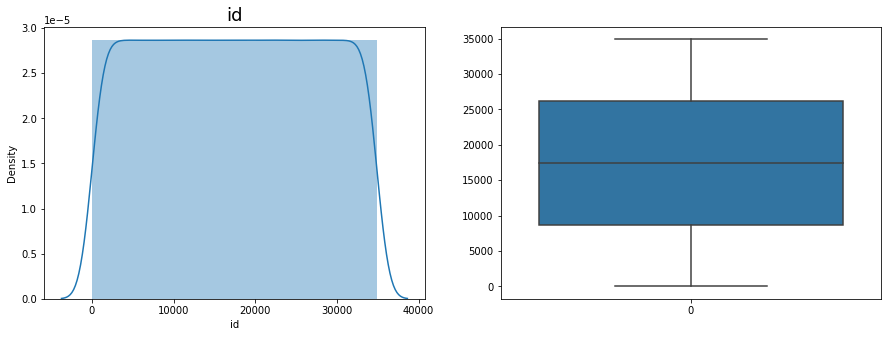

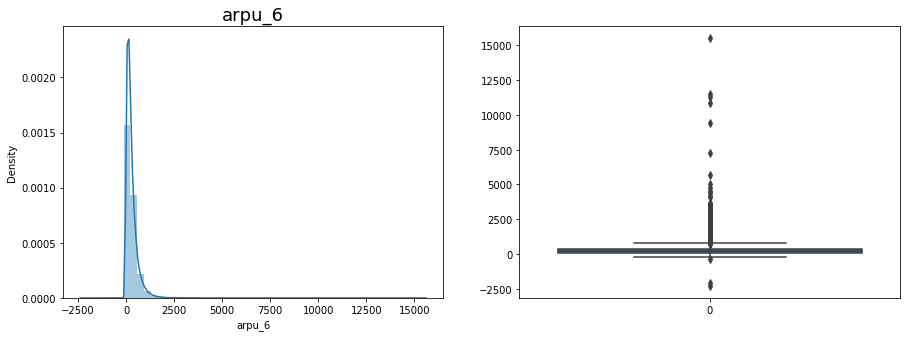

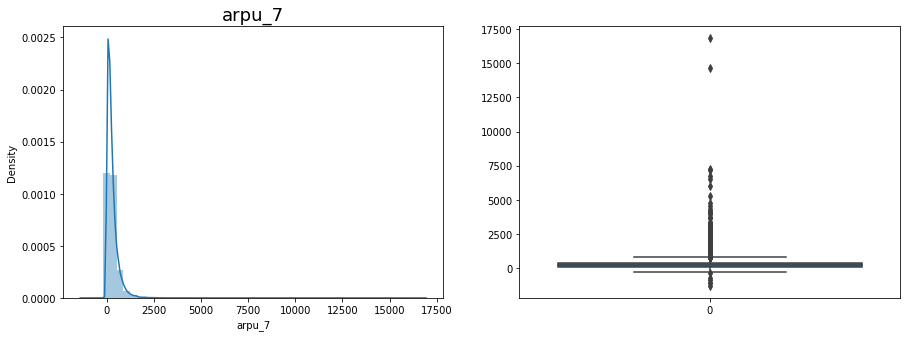

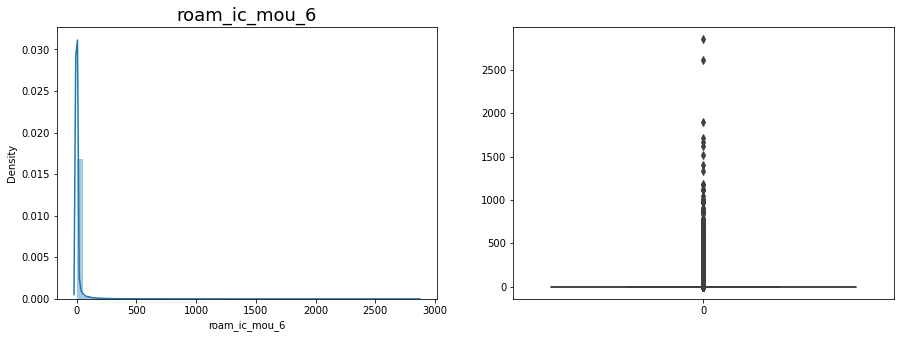

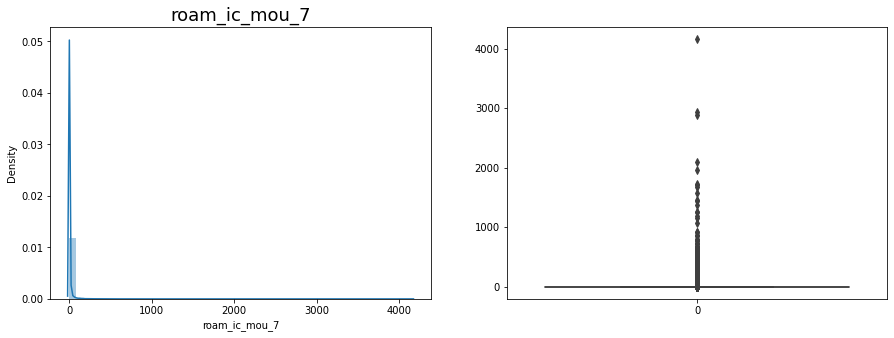

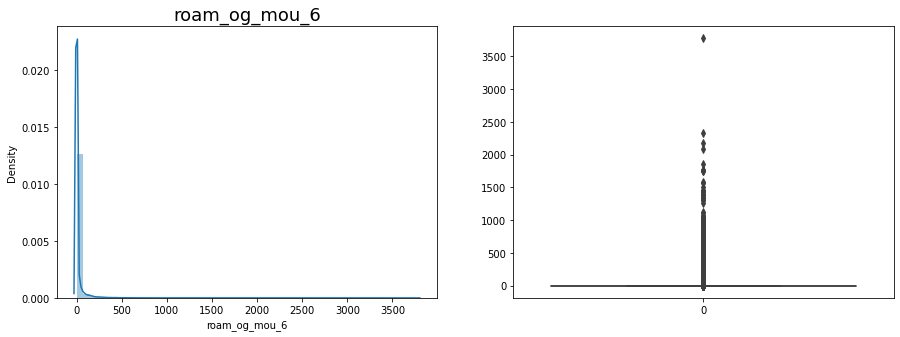

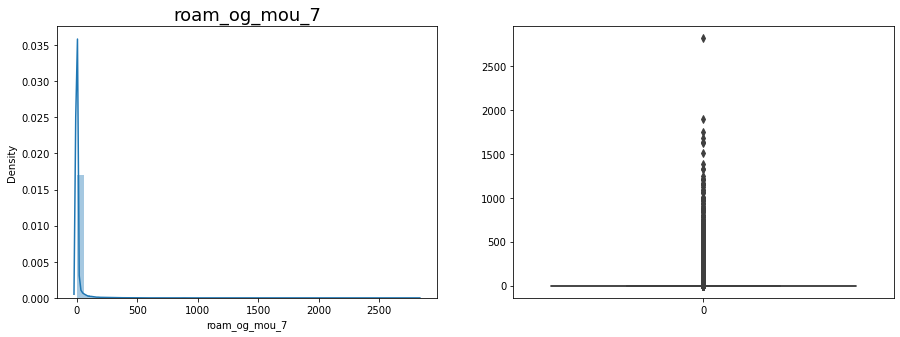

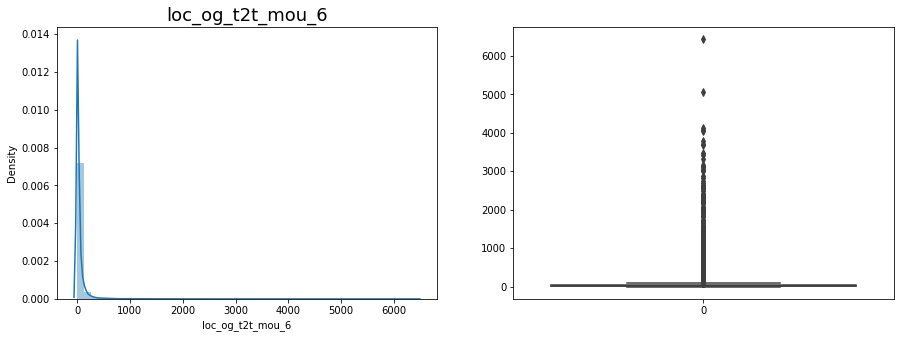

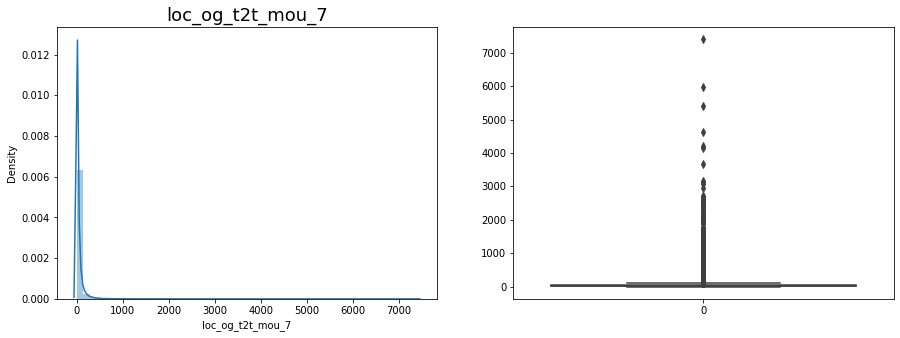

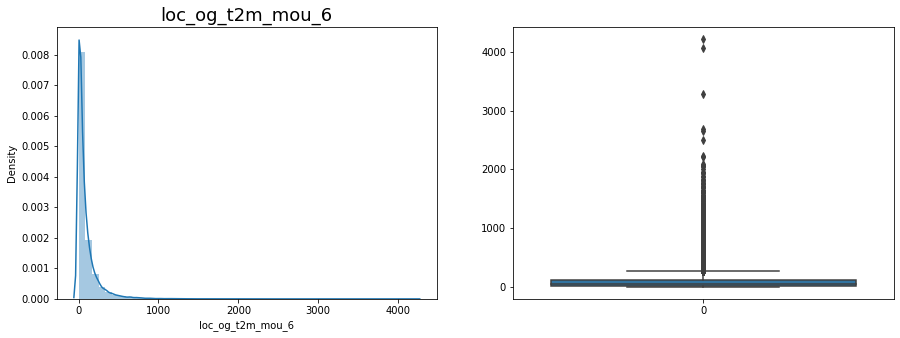

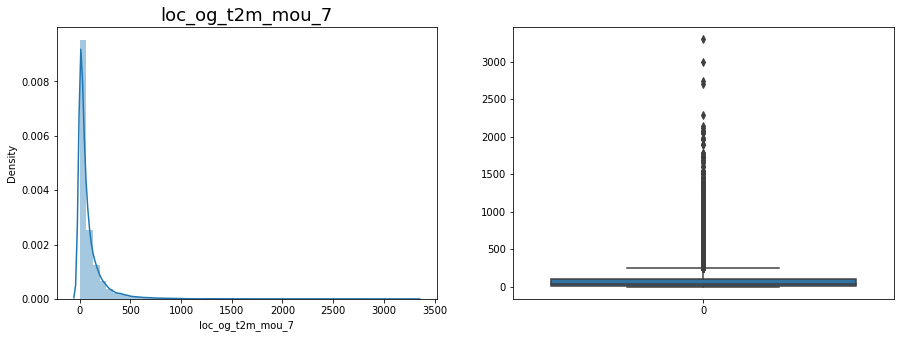

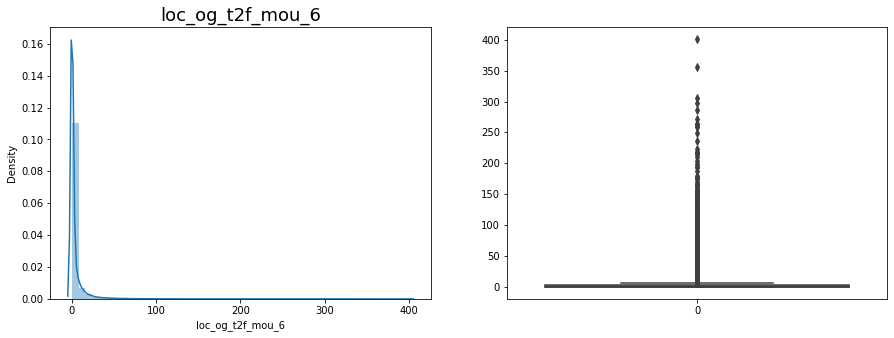

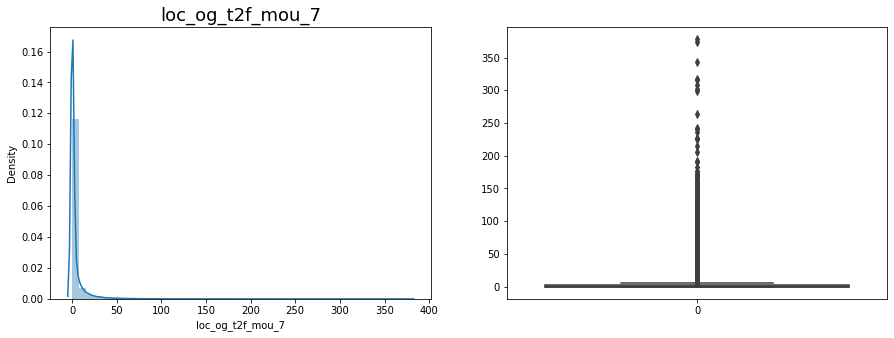

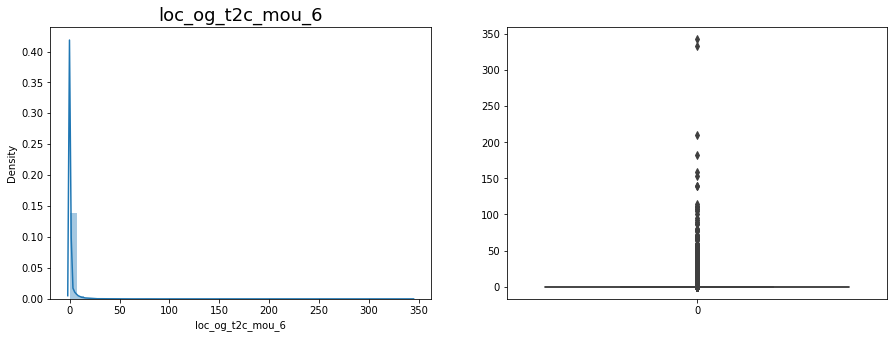

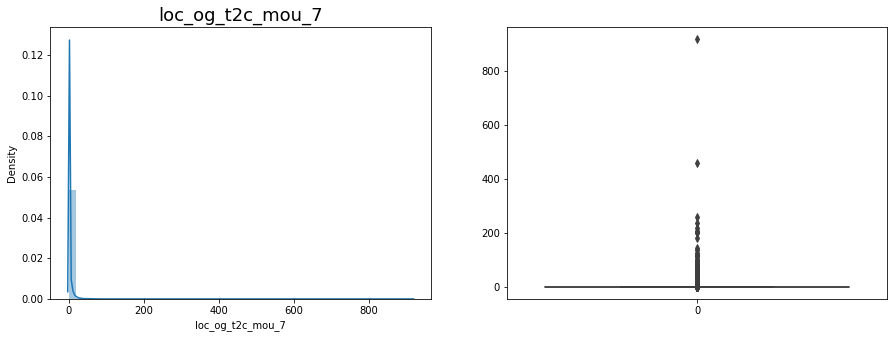

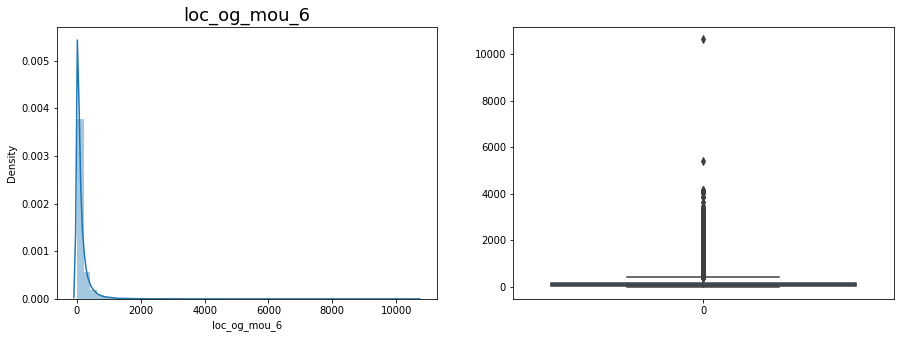

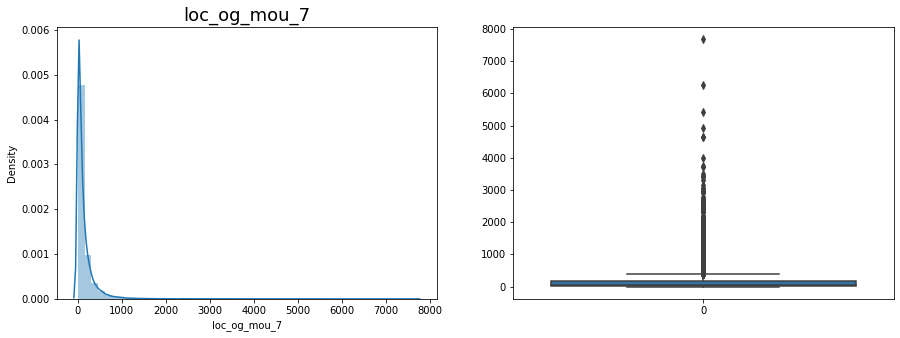

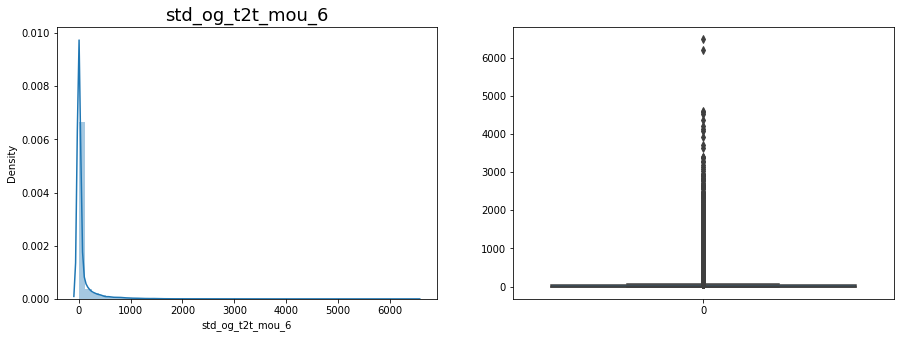

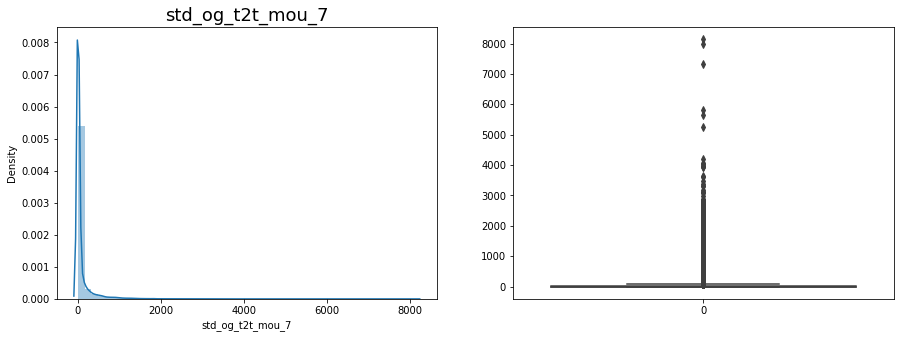

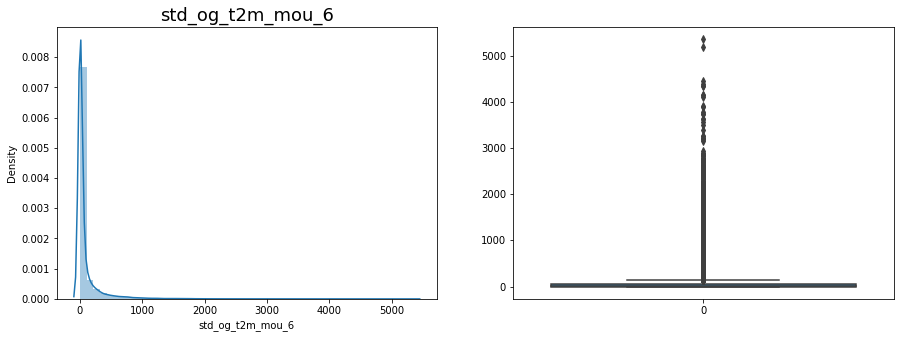

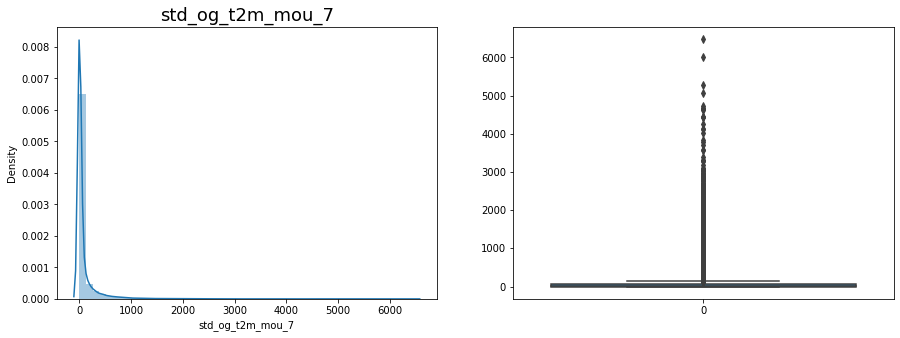

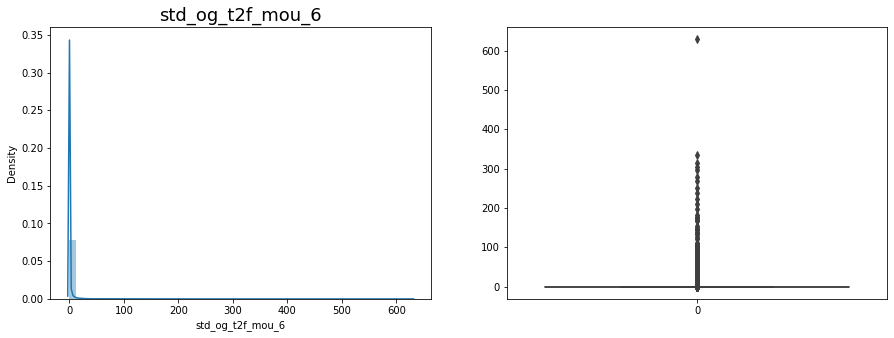

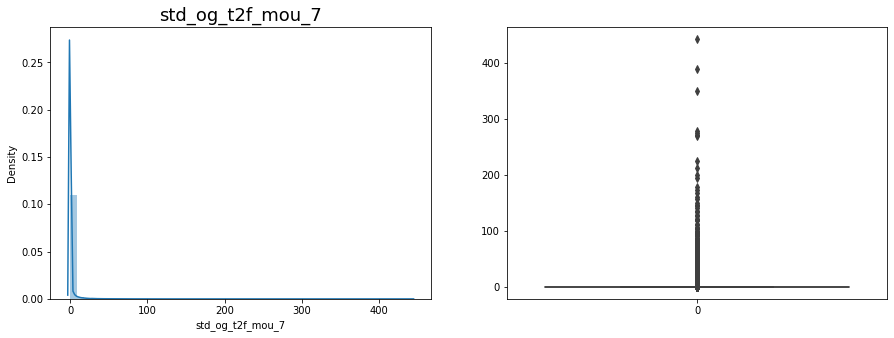

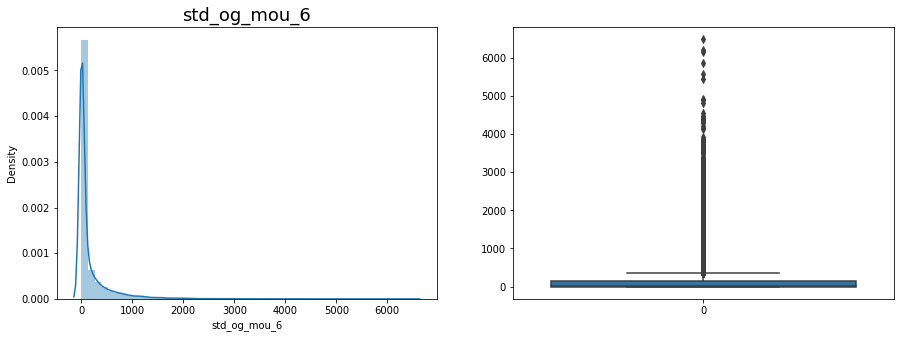

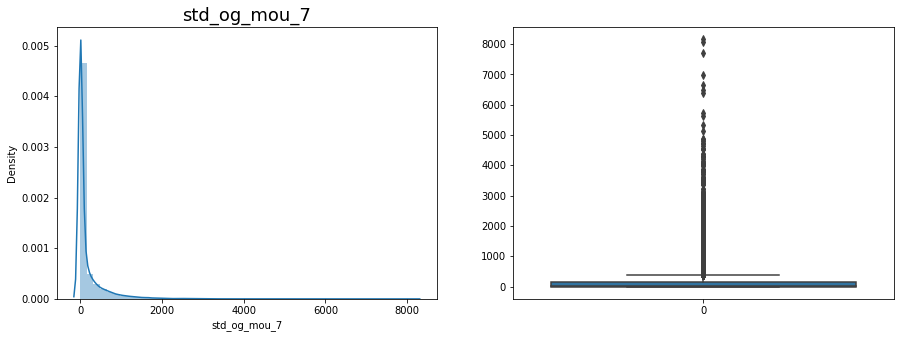

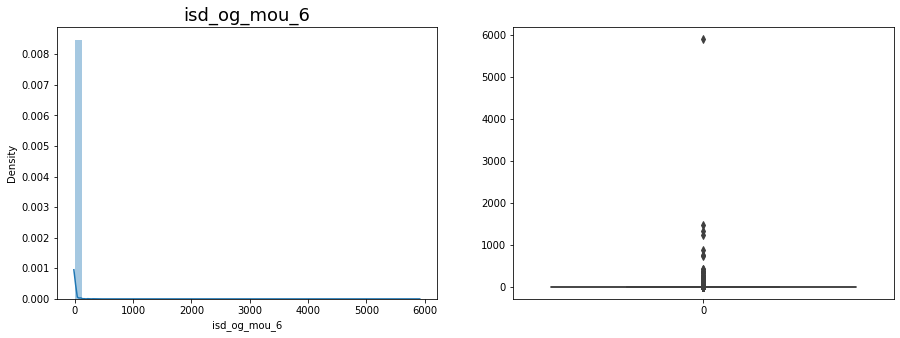

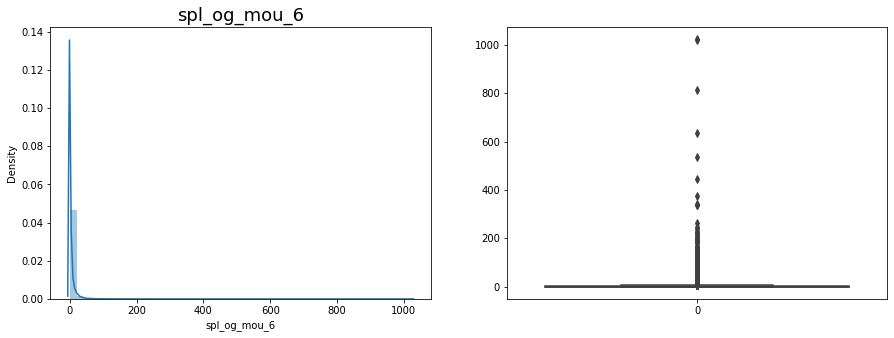

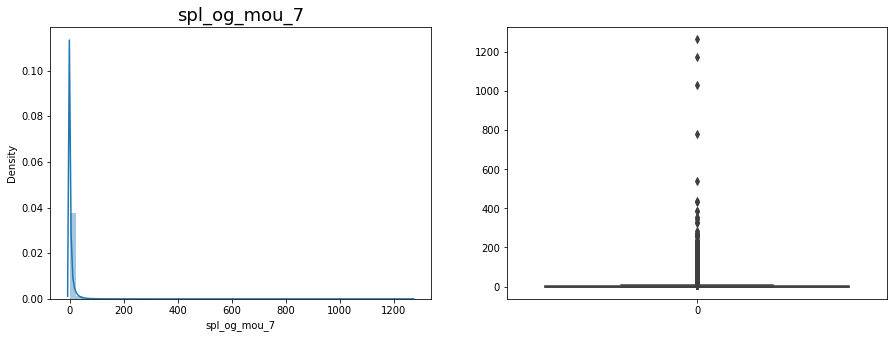

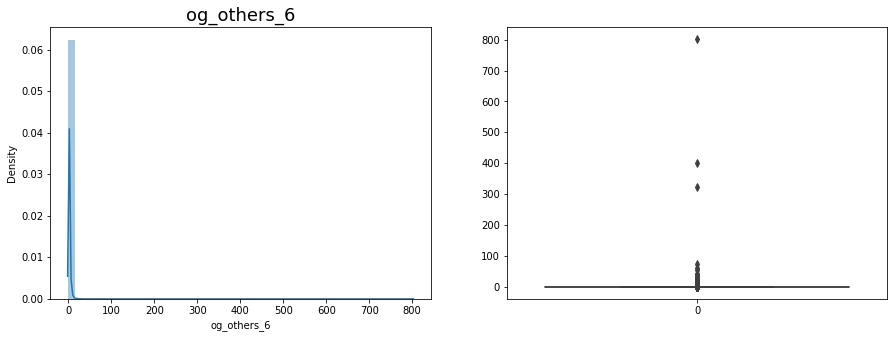

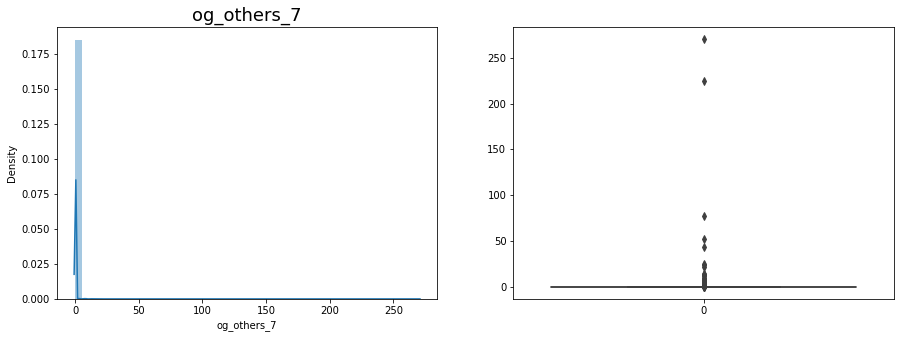

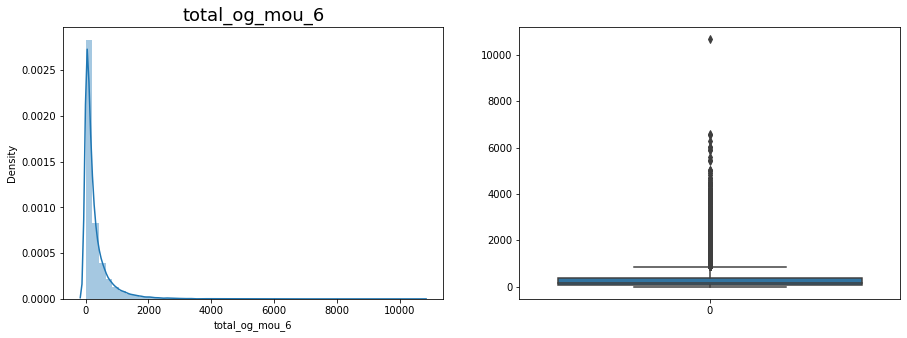

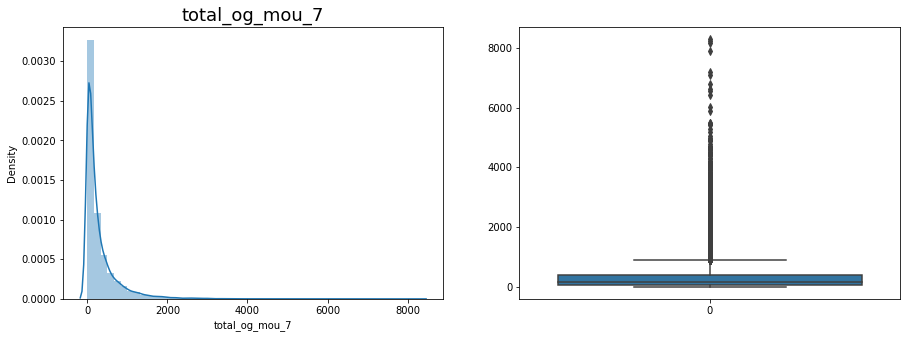

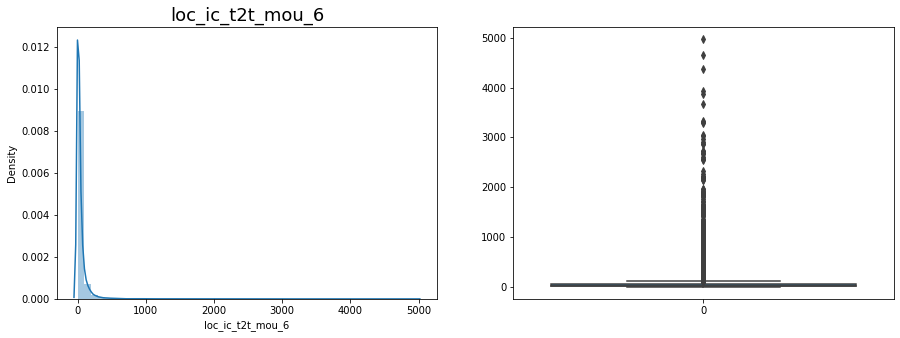

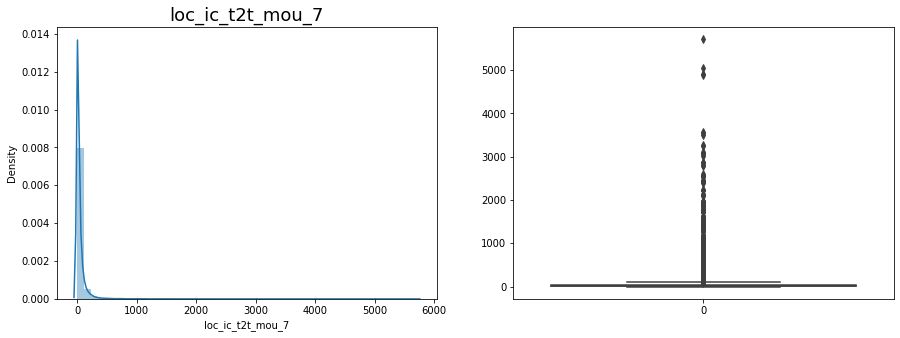

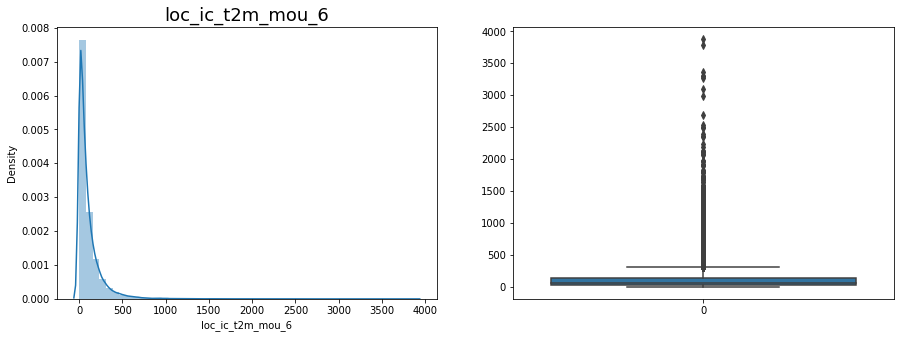

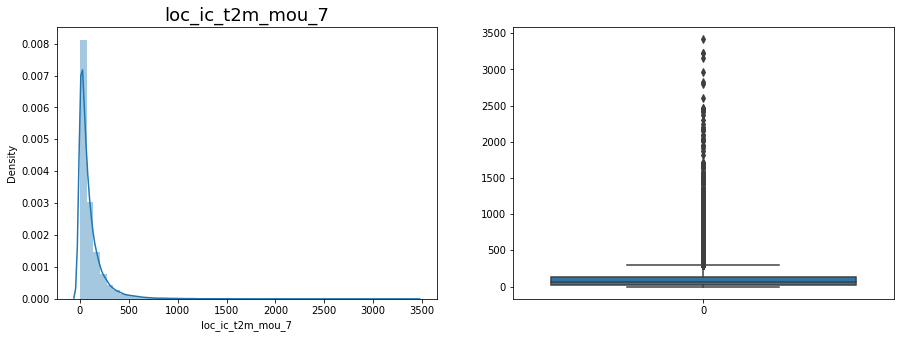

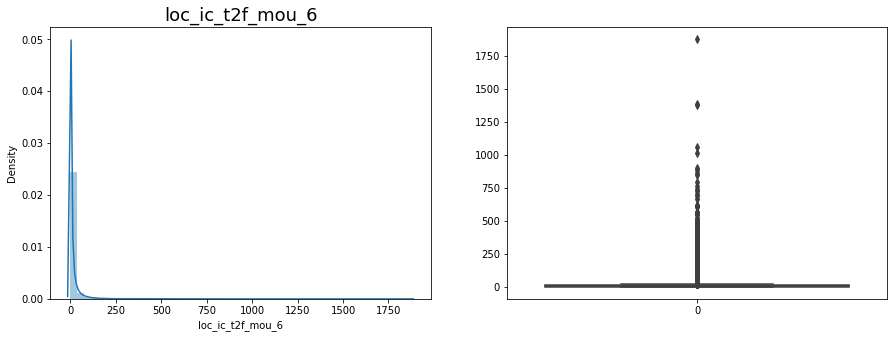

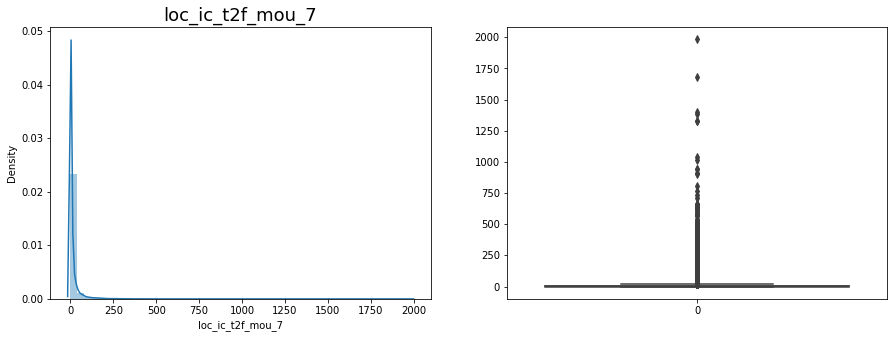

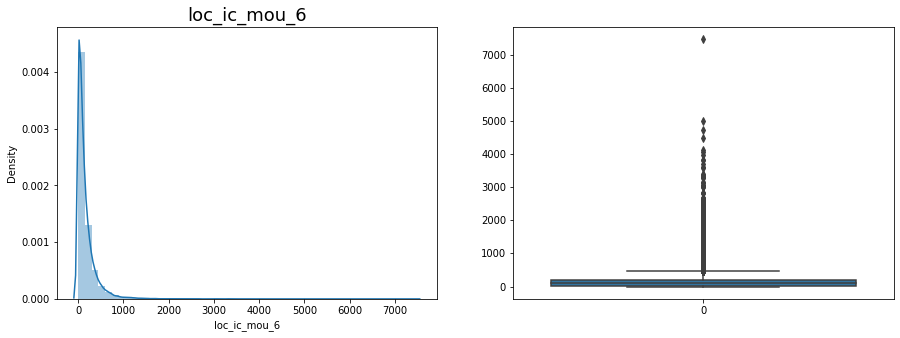

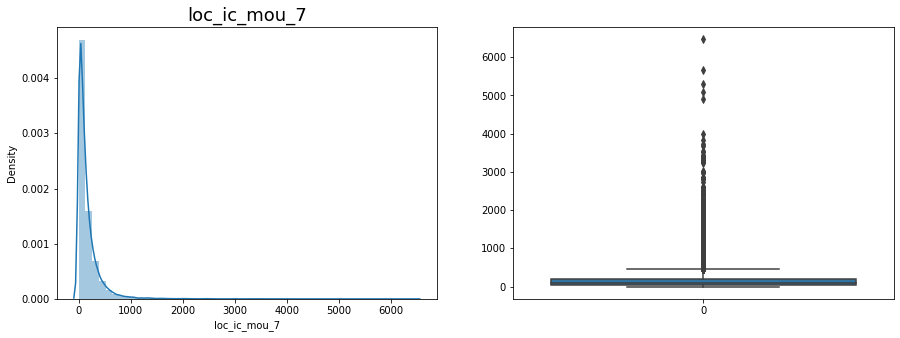

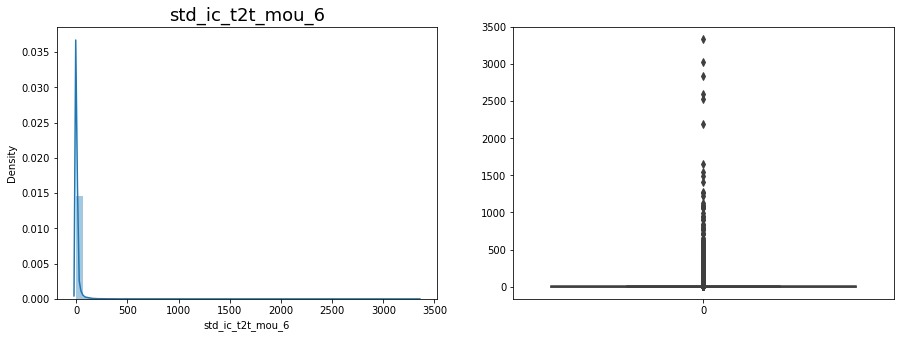

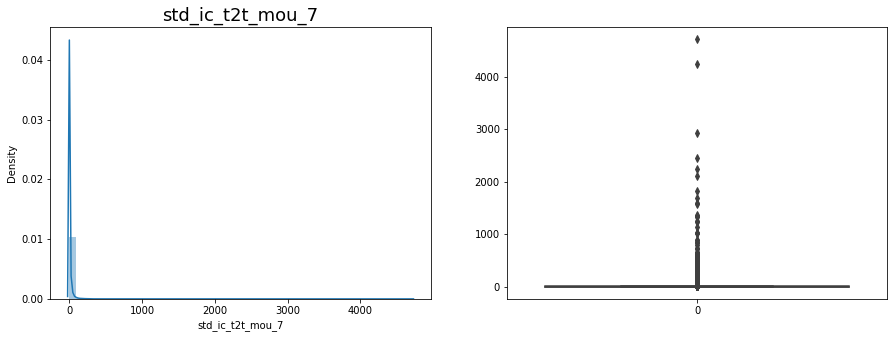

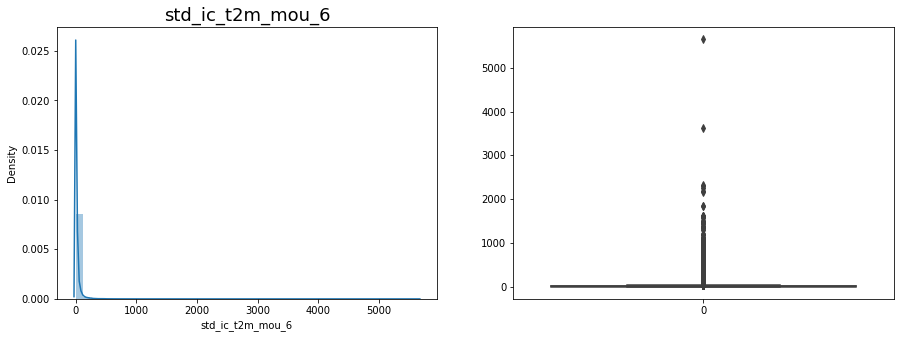

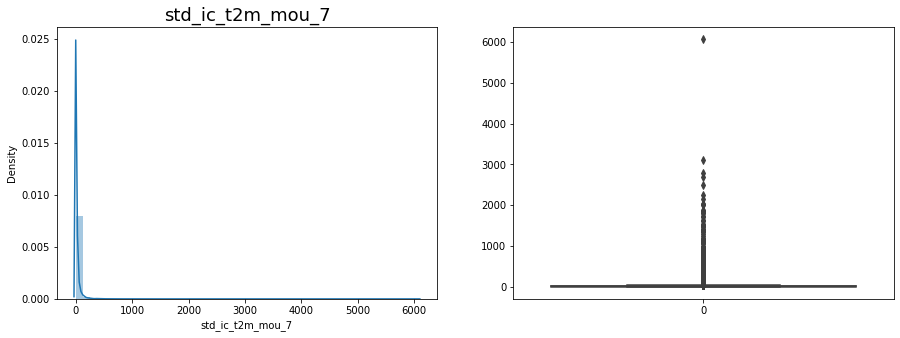

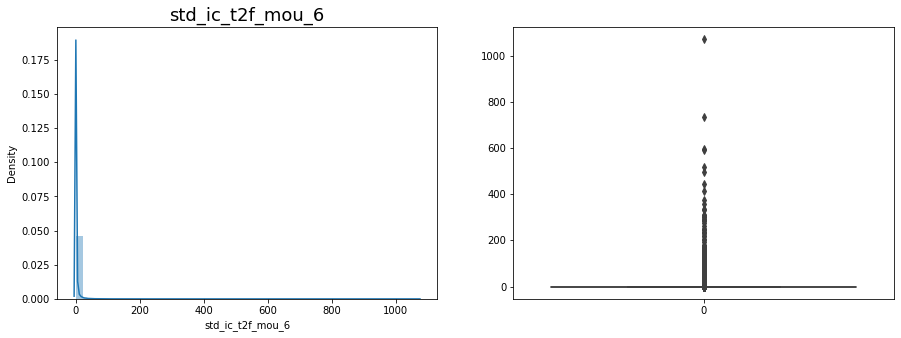

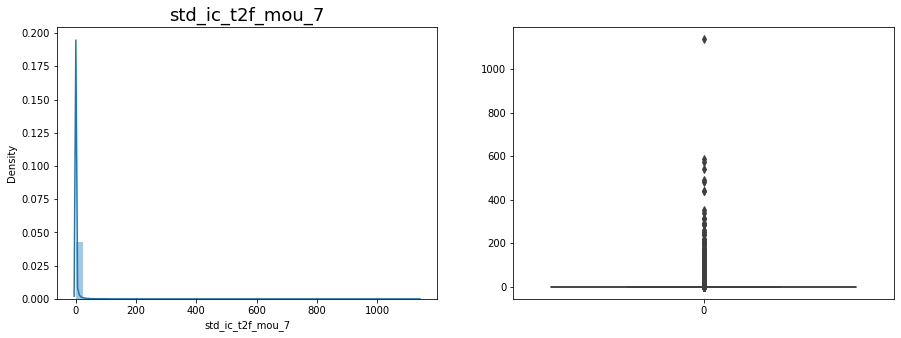

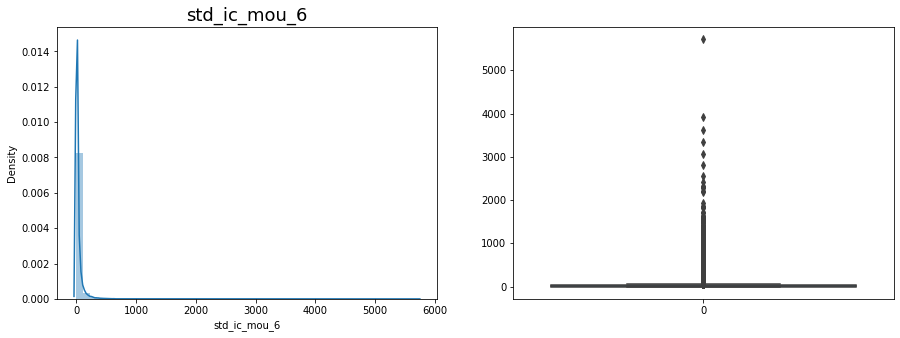

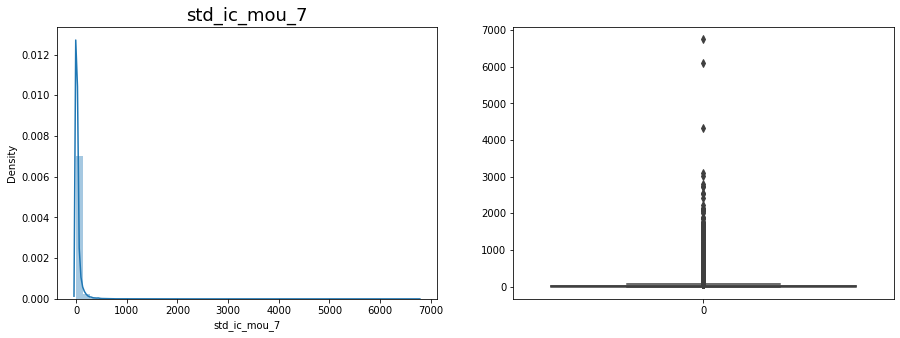

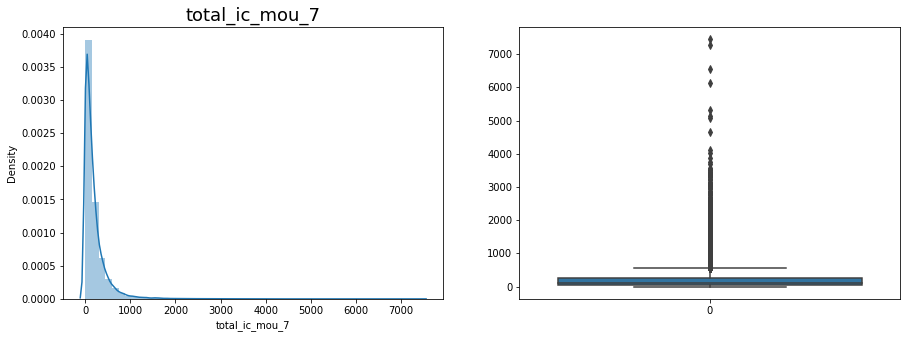

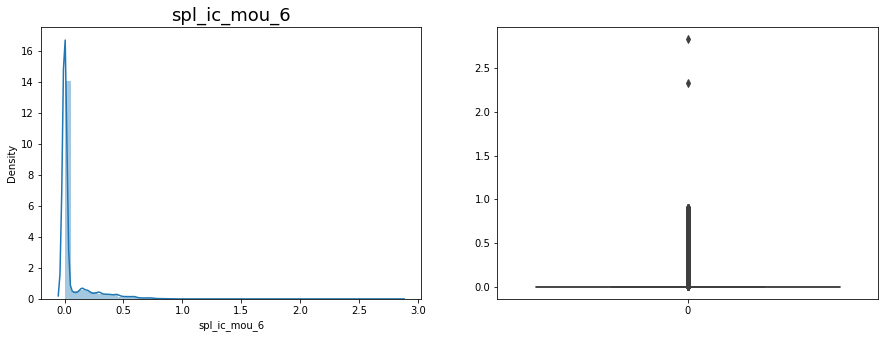

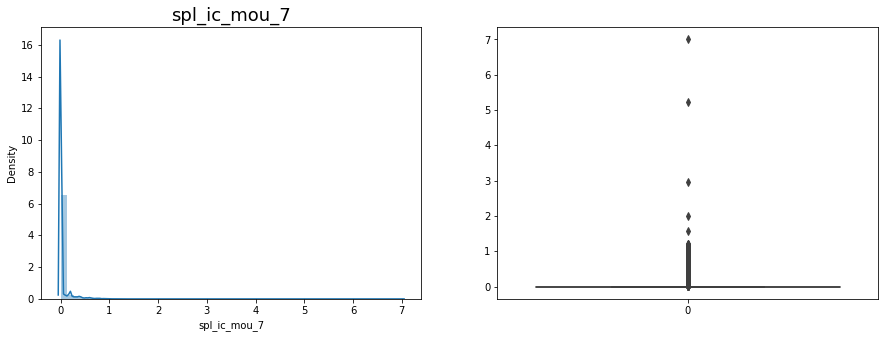

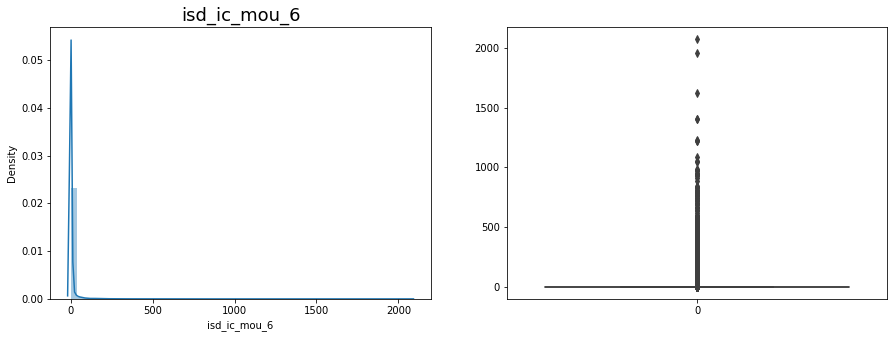

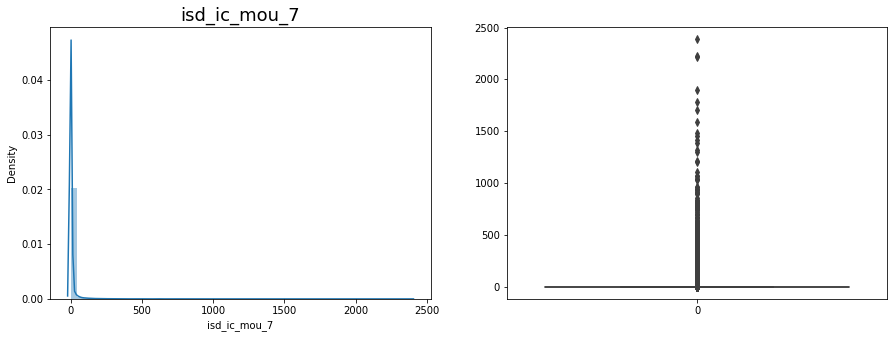

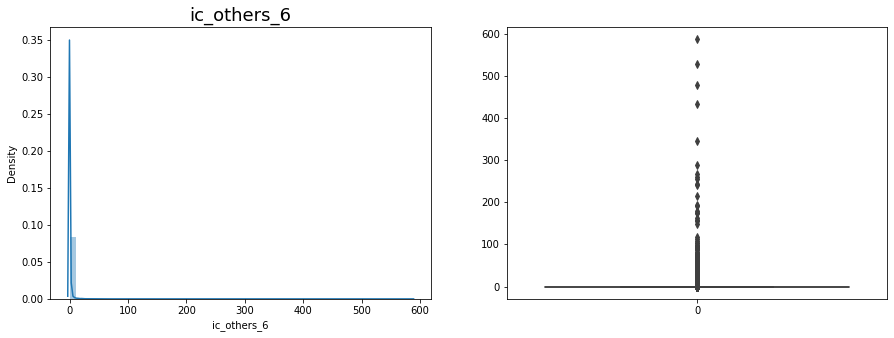

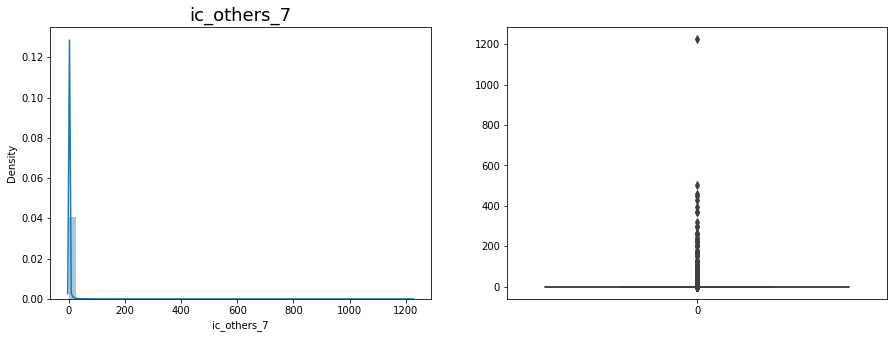

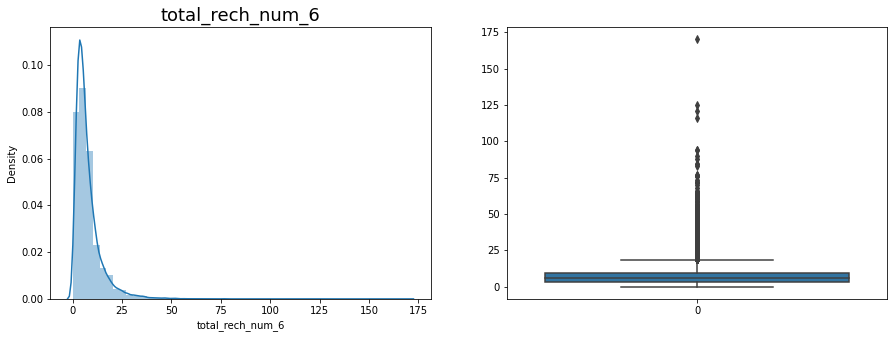

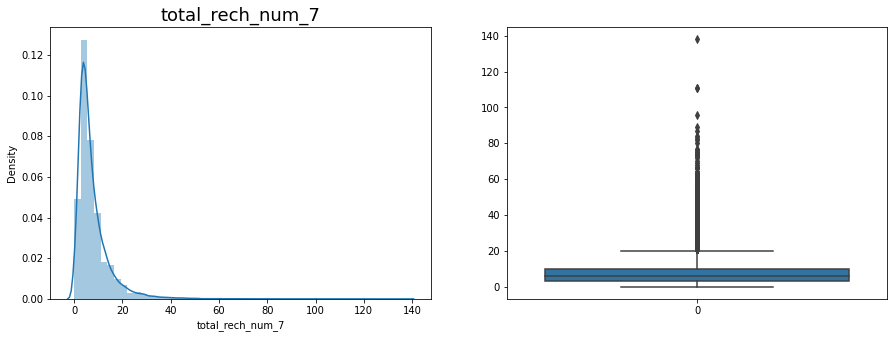

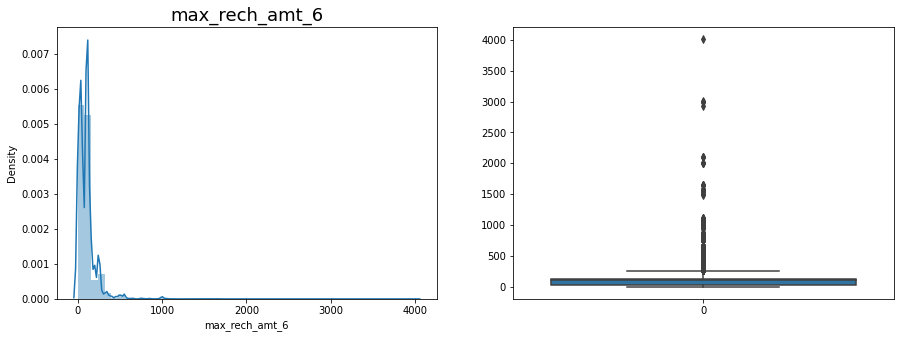

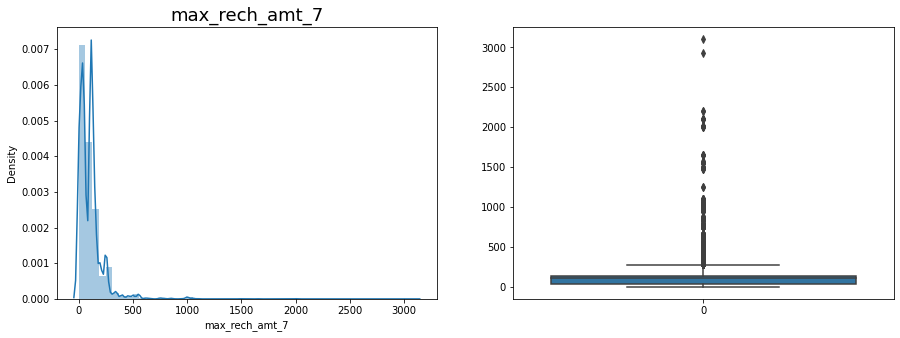

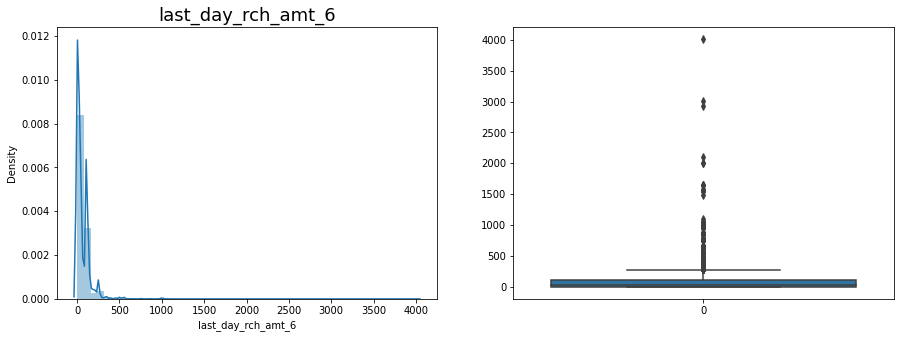

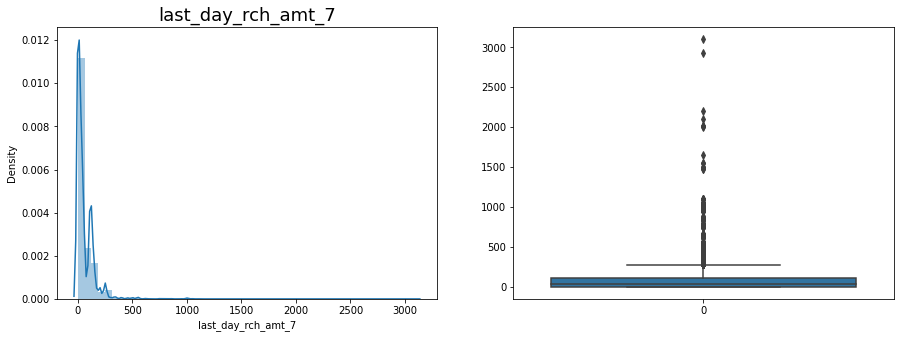

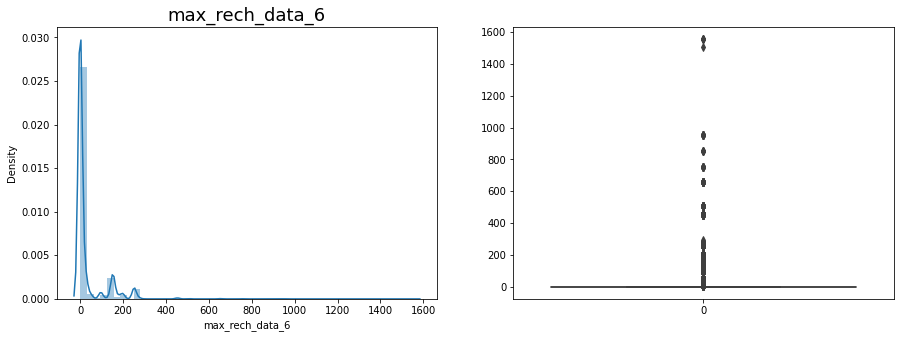

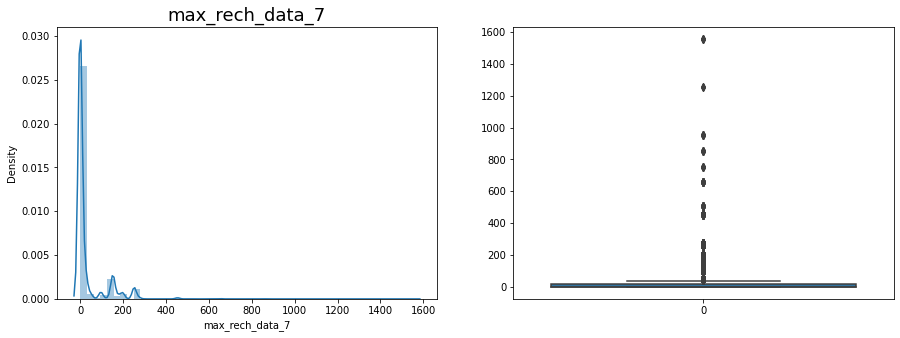

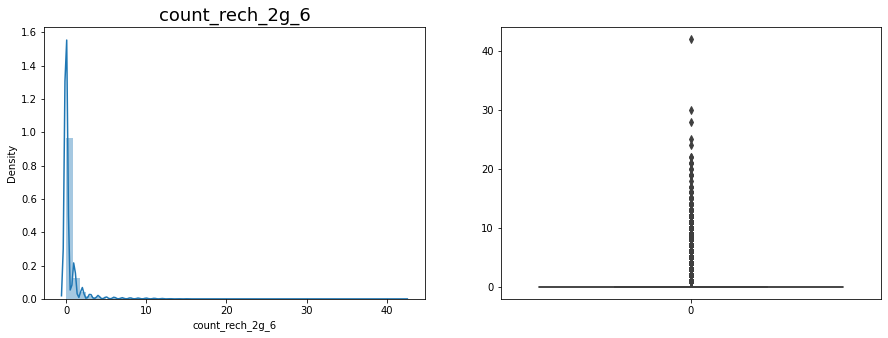

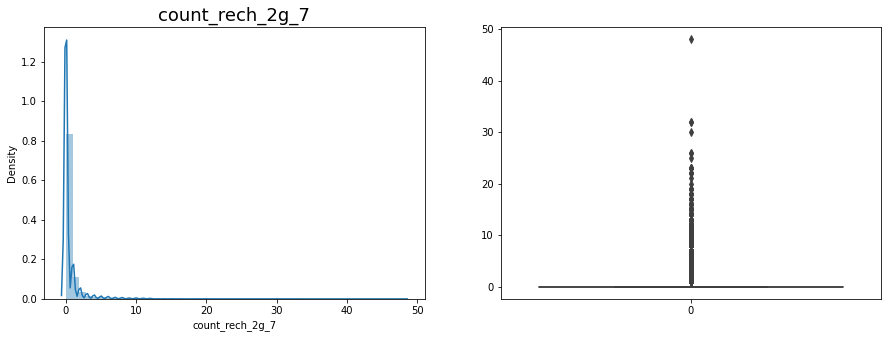

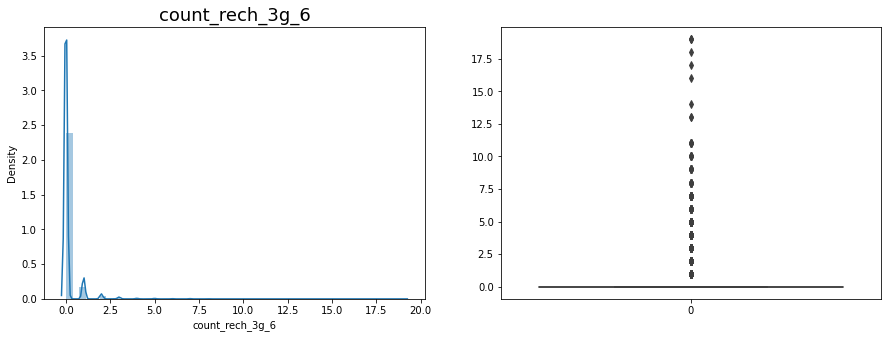

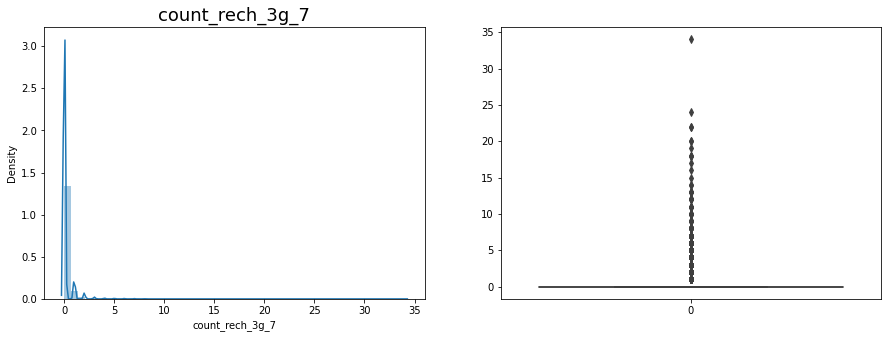

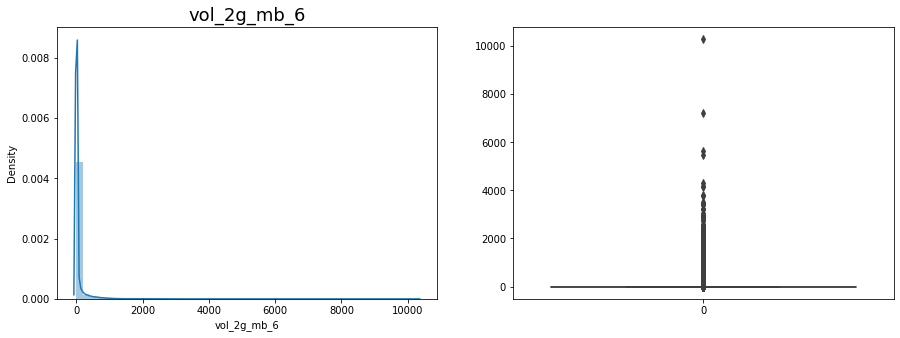

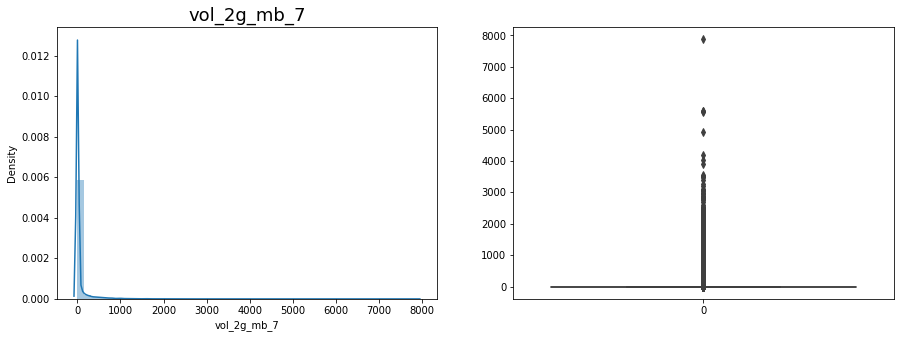

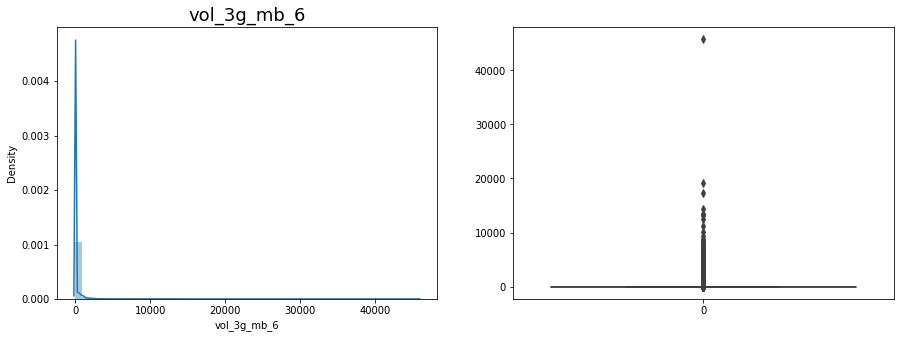

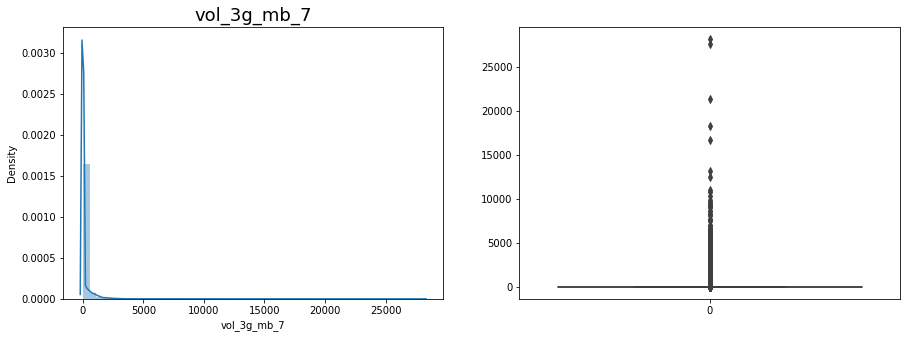

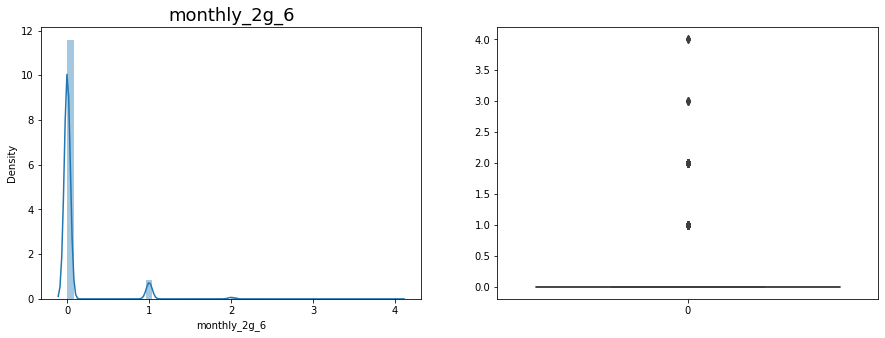

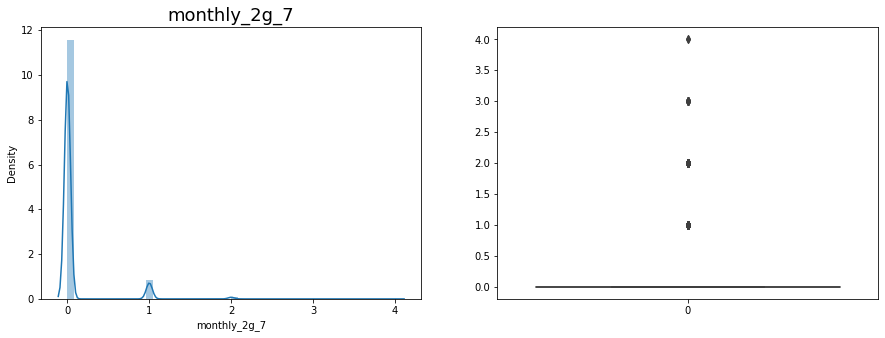

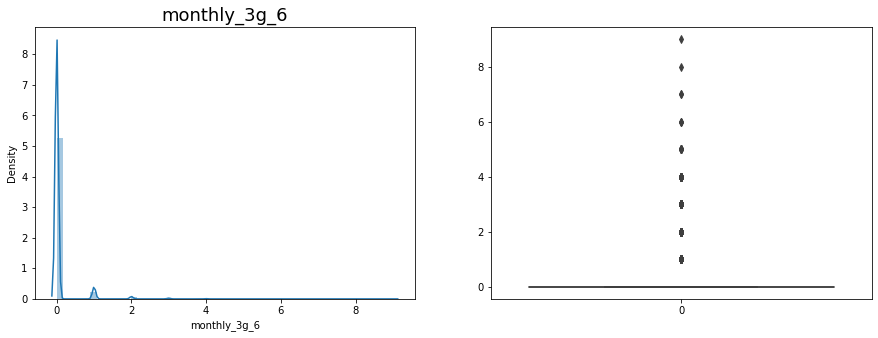

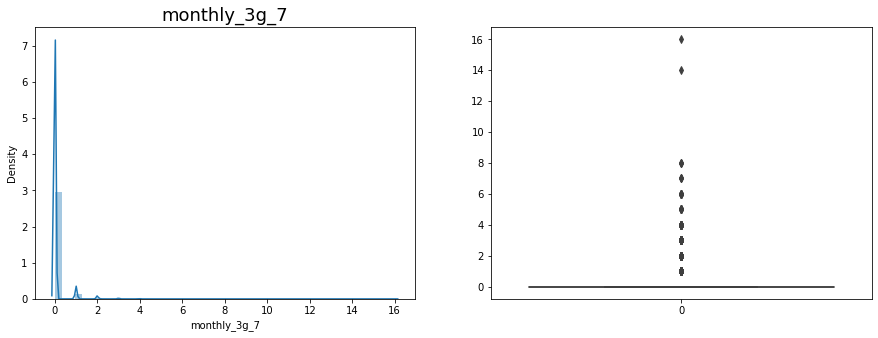

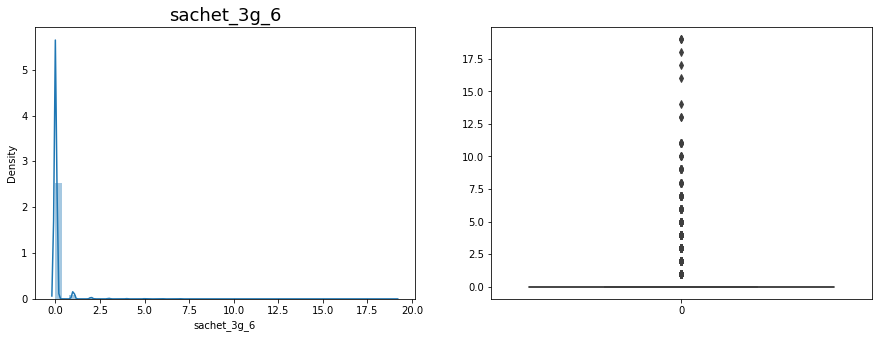

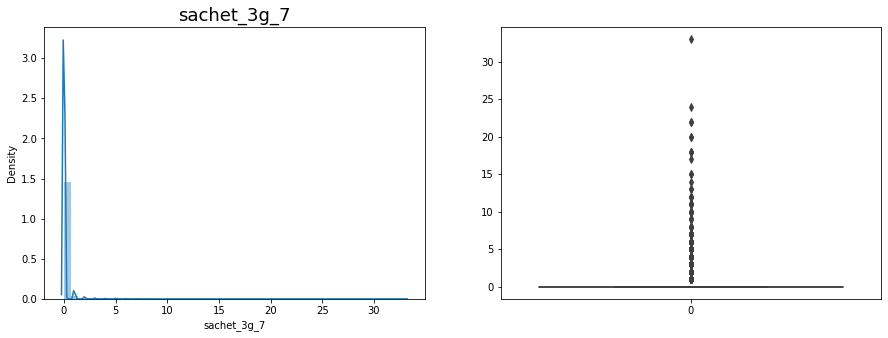

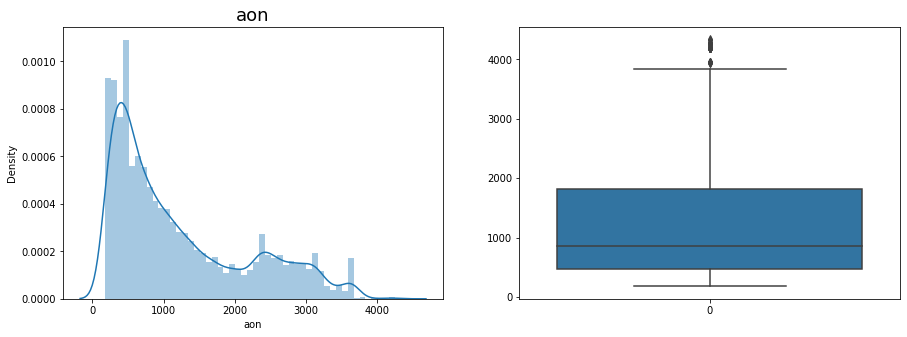

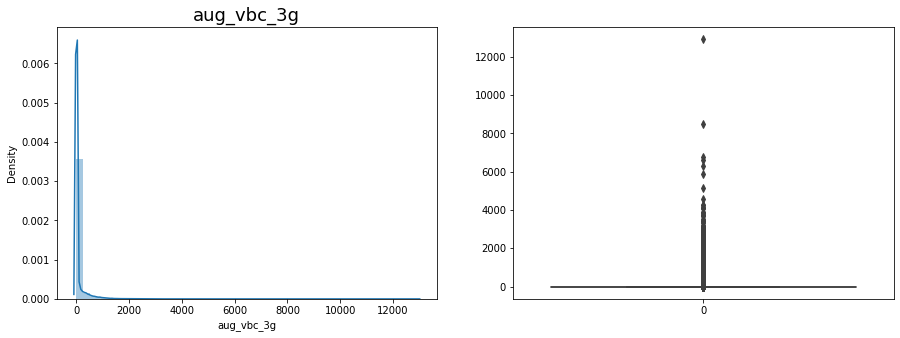

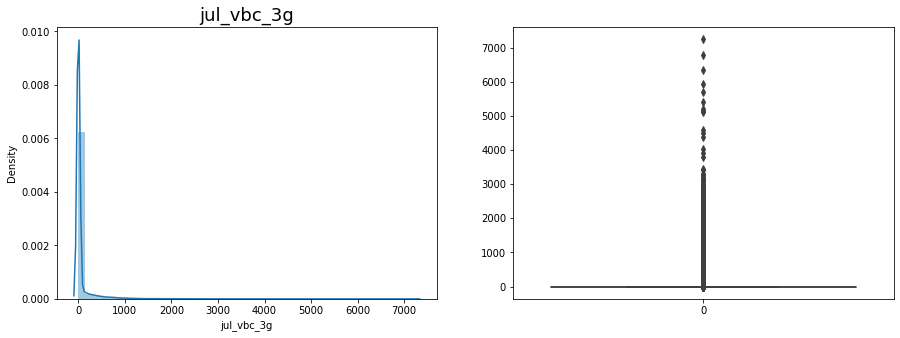

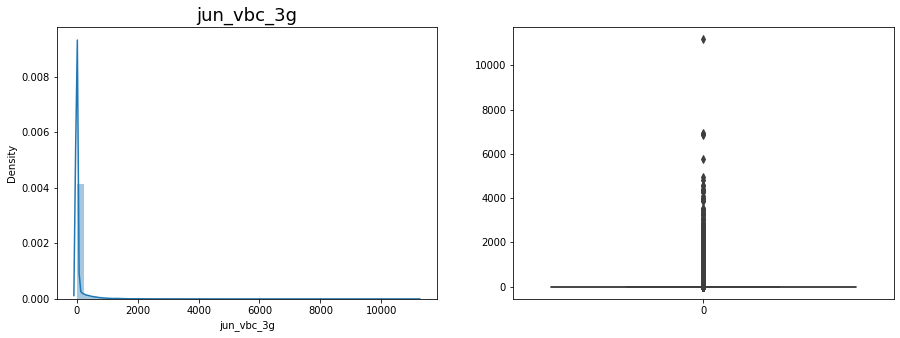

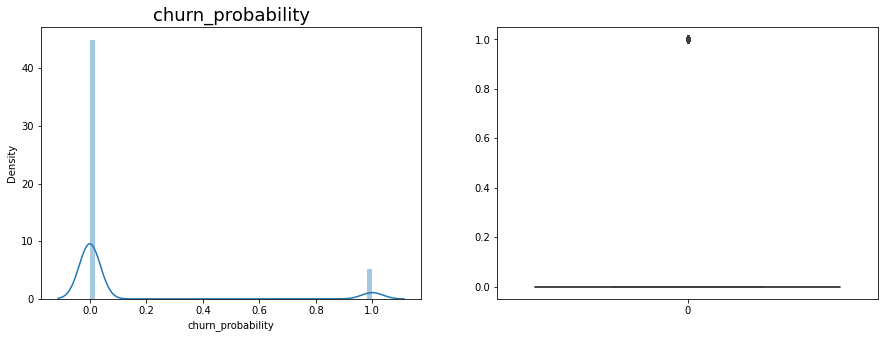

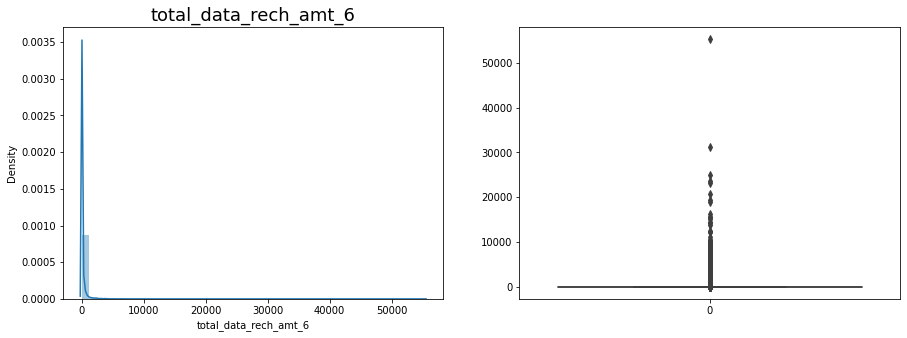

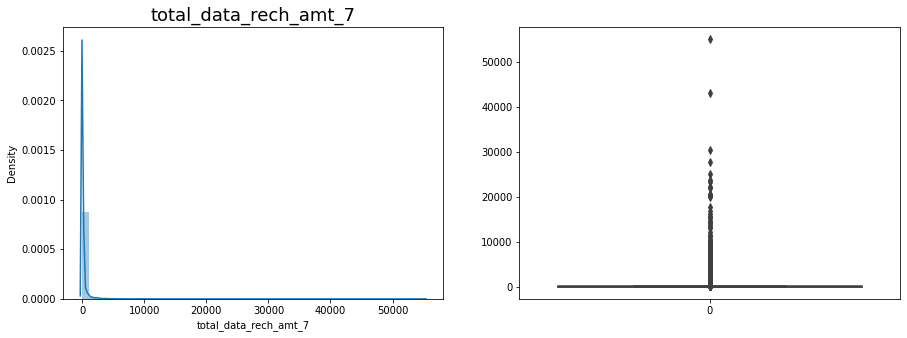

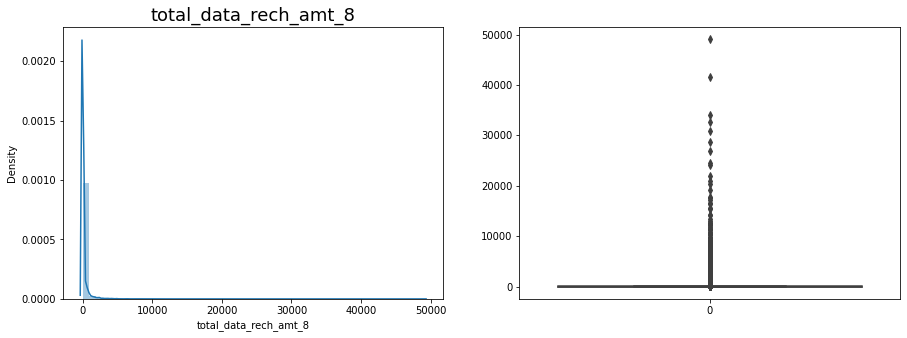

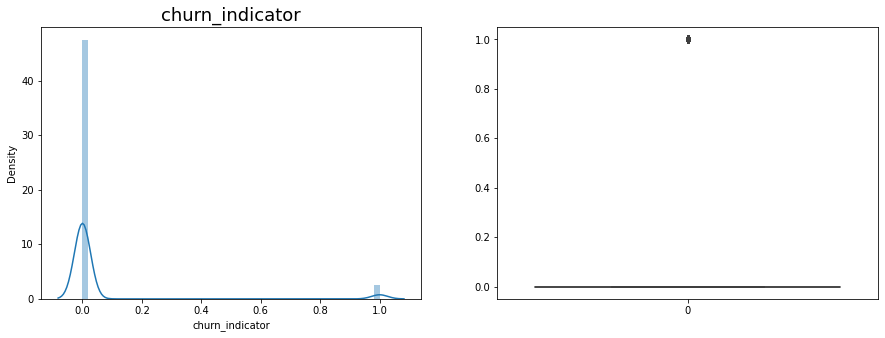

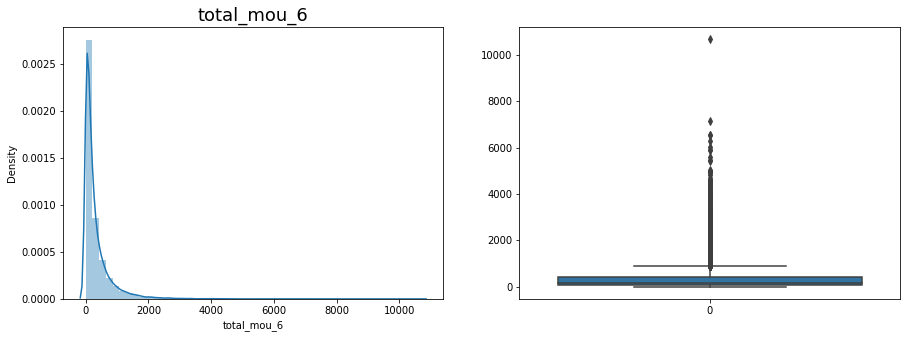

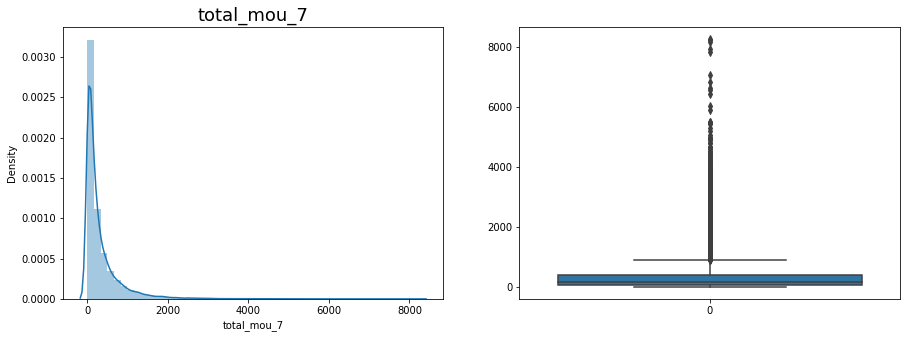

In [761]:
numerical_columns = telecom.select_dtypes(include=['number']).columns
print(numerical_columns)
for col in numerical_columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.title(col, fontdict={'fontsize': 18})
    sns.distplot(telecom[col])
    plt.subplot(1,2,2)
    sns.boxplot(telecom[col])
    plt.show() 

# inference
# from the plots it is clear that most numerical columns have outlier
# need to perform some outlier treatment


Visualise categorical columns

In [762]:
cat_columns = telecom.select_dtypes(include=['object']).columns
cat_columns

# no categorical columns

Index([], dtype='object')

Plot Correlation matrix

In [763]:
# plt.figure(figsize = (50,50))
# sns.heatmap(telecom.corr(), annot = True, cmap='RdYlGn')
# plt.show()

Inference 
- You can see high cor-relation between certain variables.
- We will use VIF and p-value to select/eliminate certain predictors during model building.

# Step 3: Data preparation and processing. 


Outlier Treatment

(34879, 88)
(34879, 88)


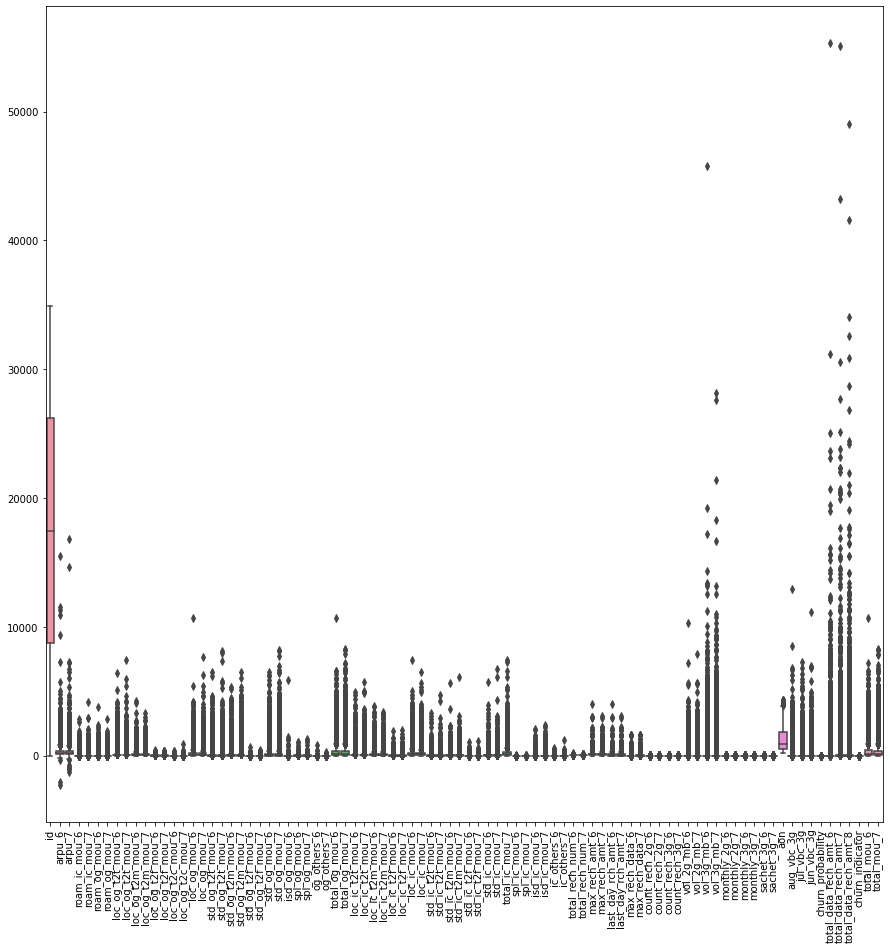

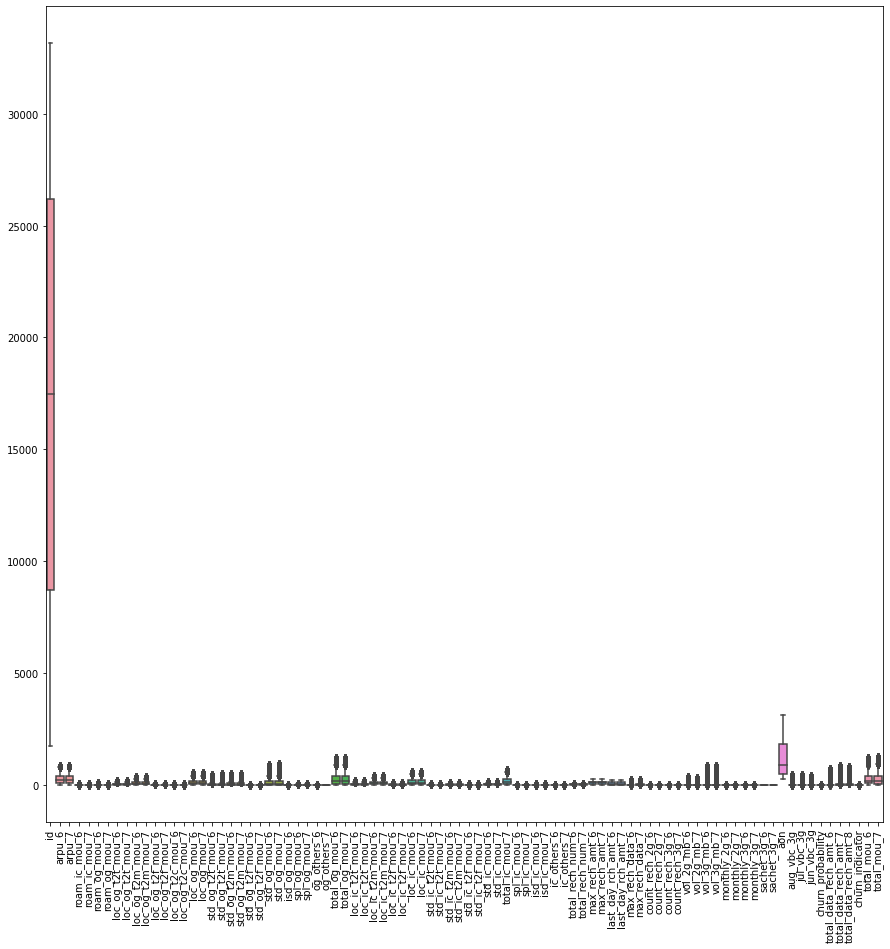

In [764]:
print(telecom.shape)
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=telecom);

# keeping values with lower bound a 5% and upper bound as 95%
telecom[numerical_columns] = telecom[numerical_columns].apply(lambda x: x.clip(*x.quantile([0.05, 0.95])))
# check boxplots again to see if outliers are treated
plt.figure(figsize=[15,15])
plt.xticks(rotation=90)
sns.boxplot(data=telecom);
print(telecom.shape)

# Outliers have been treated.

#Step 4: Model Building

In [765]:
#round(100*(telecom.isnull().sum()/len(telecom.index)), 2)
print(telecom.shape)
telecom = telecom.dropna(axis=0)
print(telecom.shape)

# 2000 rows removed.

(34879, 88)
(32802, 88)


In [766]:
X = telecom.drop(["id", "churn_probability"], axis=1).copy()
X.head()

,arpu_6,arpu_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn_indicator,total_mou_6,total_mou_7
0,31.277,87.009,0.0000,0.0,0.00,0.0,2.23,0.00,5.29,16.04,...,1958.0,0.0,0.0,0.0,0.0,0.0,0.0,0,80.82,221.06
1,1.000,122.787,0.0000,0.0,0.00,0.0,0.00,0.00,0.00,0.00,...,710.0,0.0,0.0,0.0,0.0,145.0,0.0,0,0.00,25.99
2,60.806,103.176,0.0000,0.0,0.00,0.0,0.53,12.98,24.11,0.00,...,882.0,0.0,0.0,0.0,0.0,0.0,0.0,0,54.52,97.98
3,156.362,205.260,0.0000,0.0,0.00,0.0,6.99,3.94,37.91,44.89,...,982.0,0.0,0.0,0.0,0.0,0.0,0.0,0,76.02,94.49
4,240.708,128.191,42.7375,0.0,15.73,0.0,10.16,4.83,36.74,19.88,...,647.0,0.0,0.0,0.0,686.0,820.5,808.0,0,78.27,42.94


In [767]:
# y = telecom["churn"].copy()
y = telecom["churn_probability"].copy()
y.head()


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: churn_probability, dtype: float64

In [768]:
#train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
print(X_train.shape)
print(y_train.shape)

(26241, 86)
(26241,)


Scaling

In [769]:
numerical_columns = X_train.select_dtypes(include=['int64', 'float64']).columns

In [770]:
## Create a scaling instance
scaler = StandardScaler()
## Scale the numerical columns 
X_train[numerical_columns] = scaler.fit_transform(X_train[numerical_columns])
X_test[numerical_columns] = scaler.transform(X_test[numerical_columns])
X_train.describe()

,arpu_6,arpu_7,roam_ic_mou_6,roam_ic_mou_7,roam_og_mou_6,roam_og_mou_7,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2m_mou_6,loc_og_t2m_mou_7,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,total_data_rech_amt_6,total_data_rech_amt_7,total_data_rech_amt_8,churn_indicator,total_mou_6,total_mou_7
count,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,...,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04,2.624100e+04
mean,-9.192838e-17,-5.686291e-17,9.866393e-17,-6.227843e-18,6.451233e-17,-1.232030e-17,-1.248276e-16,5.686291e-17,-1.314616e-16,7.649416e-18,...,-3.357620e-17,-7.744187e-17,3.845016e-17,6.606929e-17,-2.247439e-17,2.328672e-17,-4.603188e-17,7.825420e-17,-8.123274e-17,8.881446e-17
std,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,...,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00,1.000019e+00
min,-1.212280e+00,-1.185506e+00,-3.537976e-01,-3.293455e-01,-3.616196e-01,-3.296058e-01,-6.990096e-01,-6.955595e-01,-8.274718e-01,-8.261750e-01,...,-1.091575e+00,-3.562838e-01,-3.485462e-01,-3.392979e-01,-4.272275e-01,-4.238544e-01,-4.295040e-01,-1.846275e-01,-9.050294e-01,-8.787088e-01
25%,-7.584635e-01,-7.625311e-01,-3.537976e-01,-3.293455e-01,-3.616196e-01,-3.296058e-01,-6.598380e-01,-6.573493e-01,-7.233269e-01,-7.182024e-01,...,-8.225392e-01,-3.562838e-01,-3.485462e-01,-3.392979e-01,-4.272275e-01,-4.238544e-01,-4.295040e-01,-1.846275e-01,-7.147433e-01,-7.072942e-01
50%,-2.896802e-01,-2.986028e-01,-3.537976e-01,-3.293455e-01,-3.616196e-01,-3.296058e-01,-4.405623e-01,-4.385092e-01,-3.976950e-01,-4.049355e-01,...,-3.571508e-01,-3.562838e-01,-3.485462e-01,-3.392979e-01,-4.272275e-01,-4.238544e-01,-4.295040e-01,-1.846275e-01,-3.916103e-01,-4.023654e-01
75%,4.894845e-01,4.772817e-01,-3.537976e-01,-3.293455e-01,-3.616196e-01,-3.296058e-01,1.846931e-01,1.778468e-01,3.201684e-01,3.097305e-01,...,7.211618e-01,-3.562838e-01,-3.485462e-01,-3.392979e-01,-3.498628e-01,-3.443044e-01,-3.204160e-01,-1.846275e-01,3.404824e-01,3.341939e-01
max,2.488687e+00,2.488628e+00,3.691851e+00,3.768263e+00,3.628570e+00,3.743481e+00,2.991114e+00,3.005334e+00,2.799646e+00,2.795555e+00,...,2.029456e+00,3.514519e+00,3.572984e+00,3.630948e+00,3.363646e+00,3.415602e+00,3.402804e+00,5.416310e+00,2.716265e+00,2.732139e+00


## Logistic Regression Model

Reusable functions for logistic regression

In [771]:
# Let's re-run the model using the selected variables
def build_glm_print_summary(X_train, y_train, col):
  X_train_sm = sm.add_constant(X_train[col])
  logm = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
  res = logm.fit()
  print(res.summary())
  return res

def glm_predict(model, X_train_sm, y_train):
  # Getting the predicted values on the train set
  y_train_pred = model.predict(X_train_sm)
  print(y_train_pred[:10])
  # creating a df
  y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
  y_train_pred_final['id'] = y_train.index
  print(y_train_pred_final.head())
  y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)
  y_train_pred_final.head()
  return y_train_pred_final

def print_confusion_matrix_accuracy(y_train_pred_final):
  # Confusion matrix 
  confusion = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
  print("confusion matrix")
  print(confusion)
  # Let's check the overall accuracy.
  print("Accuracy")
  print(metrics.accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))
  return confusion

def check_VIF(X_train):
  # Create a dataframe that will contain the names of all the feature variables and their respective VIFs
  vif = pd.DataFrame()
  vif['Features'] = X_train[col].columns
  vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
  vif['VIF'] = round(vif['VIF'], 2)
  vif = vif.sort_values(by = "VIF", ascending = False)
  print(vif)

In [772]:
# Initial logistic regression model
# Logistic regression model
logm1 = build_glm_print_summary(sm.add_constant(X_train),y_train,numerical_columns)


                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26157
Model Family:                Binomial   Df Model:                           83
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5291.0
Date:                Wed, 29 Mar 2023   Deviance:                       10582.
Time:                        16:29:00   Pearson chi2:                 2.73e+04
No. Iterations:                    17   Pseudo R-squ. (CS):             0.1552
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.17

Feature Selection Using RFE

In [773]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [774]:
from sklearn.feature_selection import RFE
rfe = RFE(logreg, n_features_to_select=15)             # running RFE with 15 variables as output
rfe = rfe.fit(X_train, y_train)

In [775]:
rfe.support_

array([ True, False, False,  True, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True, False, False, False,
       False, False, False,  True,  True, False, False,  True,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False, False,
       False,  True,  True, False, False])

In [776]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('arpu_6', True, 1),
 ('arpu_7', False, 15),
 ('roam_ic_mou_6', False, 43),
 ('roam_ic_mou_7', True, 1),
 ('roam_og_mou_6', False, 21),
 ('roam_og_mou_7', True, 1),
 ('loc_og_t2t_mou_6', False, 5),
 ('loc_og_t2t_mou_7', False, 51),
 ('loc_og_t2m_mou_6', False, 4),
 ('loc_og_t2m_mou_7', False, 50),
 ('loc_og_t2f_mou_6', False, 64),
 ('loc_og_t2f_mou_7', False, 27),
 ('loc_og_t2c_mou_6', False, 62),
 ('loc_og_t2c_mou_7', False, 26),
 ('loc_og_mou_6', False, 3),
 ('loc_og_mou_7', False, 49),
 ('std_og_t2t_mou_6', False, 61),
 ('std_og_t2t_mou_7', False, 38),
 ('std_og_t2m_mou_6', False, 63),
 ('std_og_t2m_mou_7', False, 37),
 ('std_og_t2f_mou_6', False, 60),
 ('std_og_t2f_mou_7', False, 17),
 ('std_og_mou_6', True, 1),
 ('std_og_mou_7', True, 1),
 ('isd_og_mou_6', False, 25),
 ('spl_og_mou_6', False, 67),
 ('spl_og_mou_7', False, 47),
 ('og_others_6', False, 28),
 ('og_others_7', False, 72),
 ('total_og_mou_6', False, 20),
 ('total_og_mou_7', True, 1),
 ('loc_ic_t2t_mou_6', True, 1),
 ('

In [777]:
col = X_train.columns[rfe.support_]
col
# predictors selected by RFE

Index(['arpu_6', 'roam_ic_mou_7', 'roam_og_mou_7', 'std_og_mou_6',
       'std_og_mou_7', 'total_og_mou_7', 'loc_ic_t2t_mou_6',
       'loc_ic_t2m_mou_7', 'loc_ic_t2f_mou_6', 'last_day_rch_amt_7', 'aon',
       'aug_vbc_3g', 'jul_vbc_3g', 'total_data_rech_amt_8', 'churn_indicator'],
      dtype='object')

In [778]:
X_train.columns[~rfe.support_]
# predictors not selected by RFE

Index(['arpu_7', 'roam_ic_mou_6', 'roam_og_mou_6', 'loc_og_t2t_mou_6',
       'loc_og_t2t_mou_7', 'loc_og_t2m_mou_6', 'loc_og_t2m_mou_7',
       'loc_og_t2f_mou_6', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_6',
       'loc_og_t2c_mou_7', 'loc_og_mou_6', 'loc_og_mou_7', 'std_og_t2t_mou_6',
       'std_og_t2t_mou_7', 'std_og_t2m_mou_6', 'std_og_t2m_mou_7',
       'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'isd_og_mou_6', 'spl_og_mou_6',
       'spl_og_mou_7', 'og_others_6', 'og_others_7', 'total_og_mou_6',
       'loc_ic_t2t_mou_7', 'loc_ic_t2m_mou_6', 'loc_ic_t2f_mou_7',
       'loc_ic_mou_6', 'loc_ic_mou_7', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2m_mou_6', 'std_ic_t2m_mou_7', 'std_ic_t2f_mou_6',
       'std_ic_t2f_mou_7', 'std_ic_mou_6', 'std_ic_mou_7', 'total_ic_mou_7',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'isd_ic_mou_6', 'isd_ic_mou_7',
       'ic_others_6', 'ic_others_7', 'total_rech_num_6', 'total_rech_num_7',
       'max_rech_amt_6', 'max_rech_amt_7', 'last_day_rch_amt_

##### Assessing the model with StatsModels

In [779]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = build_glm_print_summary(X_train_sm,y_train,col)
# logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
# res = logm2.fit()
# res.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26225
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5337.4
Date:                Wed, 29 Mar 2023   Deviance:                       10675.
Time:                        16:29:46   Pearson chi2:                 2.66e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1522
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.13

In [780]:
# Getting the predicted values on the train set
y_train_pred_final = glm_predict(logm2, X_train_sm, y_train)
y_train_pred_final.head()

9575     0.054910
33941    0.055537
13296    0.167889
21440    0.003443
4913     0.418111
28485    0.056365
11449    0.008329
29697    0.004188
12055    0.017025
1461     0.061522
dtype: float64
       Churn  Churn_Prob     id
9575     0.0    0.054910   9575
33941    0.0    0.055537  33941
13296    0.0    0.167889  13296
21440    0.0    0.003443  21440
4913     0.0    0.418111   4913


,Churn,Churn_Prob,id,predicted
9575,0.0,0.054910,9575,0
33941,0.0,0.055537,33941,0
13296,0.0,0.167889,13296,0
21440,0.0,0.003443,21440,0
4913,0.0,0.418111,4913,0


In [781]:
# Confusion matrix 
print_confusion_matrix_accuracy(y_train_pred_final)

confusion matrix
[[23902   162]
 [ 1492   685]]
Accuracy
0.936968865515796


array([[23902,   162],
       [ 1492,   685]])

In [667]:
# Predicted     not_churn    churn
# Actual
# not_churn        25337      39
# churn            822       43  

## Accuracy 96% - overfitting?

In [ ]:
# Predicted     not_churn    churn
# Actual
# not_churn        23902      162
# churn            1492       685  

## Accuracy 93% - overfitting?

#### Checking VIFs

In [782]:
check_VIF(X_train)

                 Features   VIF
4            std_og_mou_7  6.88
5          total_og_mou_7  5.95
3            std_og_mou_6  3.57
2           roam_og_mou_7  3.31
1           roam_ic_mou_7  3.25
0                  arpu_6  2.75
11             aug_vbc_3g  2.65
12             jul_vbc_3g  2.48
7        loc_ic_t2m_mou_7  1.62
13  total_data_rech_amt_8  1.35
6        loc_ic_t2t_mou_6  1.32
8        loc_ic_t2f_mou_6  1.23
9      last_day_rch_amt_7  1.21
10                    aon  1.14
14        churn_indicator  1.06


There are a few variables with high VIF. It's best to drop these variables as they aren't helping much with prediction and unnecessarily making the model complex. The variable 'total_mou_7' has the highest VIF. So let's start by dropping that.

In [783]:
# col = col.drop('total_mou_7', 1)
col= col.drop('std_og_mou_7',1)
col

Index(['arpu_6', 'roam_ic_mou_7', 'roam_og_mou_7', 'std_og_mou_6',
       'total_og_mou_7', 'loc_ic_t2t_mou_6', 'loc_ic_t2m_mou_7',
       'loc_ic_t2f_mou_6', 'last_day_rch_amt_7', 'aon', 'aug_vbc_3g',
       'jul_vbc_3g', 'total_data_rech_amt_8', 'churn_indicator'],
      dtype='object')

In [786]:
X_train_sm = sm.add_constant(X_train[col])
logm3 = build_glm_print_summary(X_train_sm,y_train,col)
# Getting the predicted values on the train set
y_train_pred_final = glm_predict(logm3, X_train_sm, y_train)
y_train_pred_final.head()
confusion = print_confusion_matrix_accuracy(y_train_pred_final)
check_VIF(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:      churn_probability   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26226
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5344.0
Date:                Wed, 29 Mar 2023   Deviance:                       10688.
Time:                        16:34:54   Pearson chi2:                 2.64e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.1518
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -3.12

In [671]:
# dropping loc_og_mou_6 due to high vif
# col = col.drop('loc_og_mou_6', 1)
# col
# # model building
# X_train_sm = sm.add_constant(X_train[col])
# logm4 = build_glm_print_summary(X_train_sm,y_train,col)
# # Getting the predicted values on the train set
# y_train_pred_final = glm_predict(logm4, X_train_sm, y_train)
# print(y_train_pred_final.head())
# print_confusion_matrix_accuracy(y_train_pred_final)
# check_VIF(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26227
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2926.0
Date:                Wed, 29 Mar 2023   Deviance:                       5851.9
Time:                        11:56:32   Pearson chi2:                 2.24e+05
No. Iterations:                    13   Pseudo R-squ. (CS):            0.06461
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.22

In [672]:
# dropping loc_og_mou_6 due to high vif
# col = col.drop('loc_og_mou_7', 1)
# col
# # model building
# X_train_sm = sm.add_constant(X_train[col])
# logm5 = build_glm_print_summary(X_train_sm,y_train,col)
# # Getting the predicted values on the train set
# y_train_pred_final = glm_predict(logm5, X_train_sm, y_train)
# print(y_train_pred_final.head())
# confusion = print_confusion_matrix_accuracy(y_train_pred_final)
# check_VIF(X_train)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  churn   No. Observations:                26241
Model:                            GLM   Df Residuals:                    26228
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2930.3
Date:                Wed, 29 Mar 2023   Deviance:                       5860.7
Time:                        11:56:33   Pearson chi2:                 2.39e+05
No. Iterations:                    13   Pseudo R-squ. (CS):            0.06430
Covariance Type:            nonrobust                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -7.19

Metrics beyond simply accuracy

In [785]:
def print_other_metrics(confusion):

  TP = confusion[1,1] # true positive 
  TN = confusion[0,0] # true negatives
  FP = confusion[0,1] # false positives
  FN = confusion[1,0] # false negatives
  # Let's see the sensitivity of our logistic regression model
  print('Sensitivity is')
  print(TP / float(TP+FN))
  print('Specificity is')
  print(TN / float(TN+FP))
  print('False Positive Rate is')
  print(FP/ float(TN+FP))
  print('Positive Predictive value is')
  print (TP / float(TP+FP))
  print('Negative Predictive value is')
  print (TN / float(TN+ FN))



In [787]:
print_other_metrics(confusion)

Sensitivity is
0.31511254019292606
Specificity is
0.9931848404255319
False Positive Rate is
0.006815159574468085
Positive Predictive value is
0.8070588235294117
Negative Predictive value is
0.9412784057343153


Plotting the ROC Curve

An ROC curve demonstrates several things:

- It shows the tradeoff between sensitivity and specificity (any increase in sensitivity will be accompanied by a decrease in specificity).
- The closer the curve follows the left-hand border and then the top border of the ROC space, the more accurate the test.
- The closer the curve comes to the 45-degree diagonal of the ROC space, the less accurate the test.

In [788]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

In [789]:
fpr, tpr, thresholds = metrics.roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )

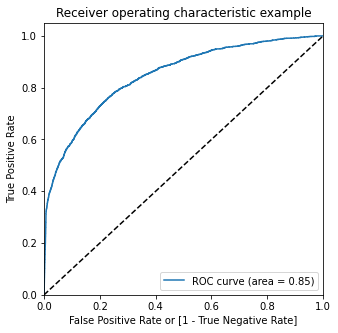

In [790]:
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

- Let us find the optimal cutoff

- Optimal cutoff probability is that prob where we get balanced sensitivity and specificity

In [791]:
# Let's create columns with different probability cutoffs 
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final[i]= y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final.head()

,Churn,Churn_Prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
9575,0.0,0.056631,9575,0,1,0,0,0,0,0,0,0,0,0
33941,0.0,0.053392,33941,0,1,0,0,0,0,0,0,0,0,0
13296,0.0,0.173584,13296,0,1,1,0,0,0,0,0,0,0,0
21440,0.0,0.004083,21440,0,1,0,0,0,0,0,0,0,0,0
4913,0.0,0.448507,4913,0,1,1,1,1,1,0,0,0,0,0


In [792]:
# Now let's calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

# TP = confusion[1,1] # true positive 
# TN = confusion[0,0] # true negatives
# FP = confusion[0,1] # false positives
# FN = confusion[1,0] # false negatives

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final.Churn, y_train_pred_final[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_df)

     prob  accuracy     sensi     speci
0.0   0.0  0.082962  1.000000  0.000000
0.1   0.1  0.851263  0.644006  0.870013
0.2   0.2  0.924050  0.440055  0.967836
0.3   0.3  0.934949  0.366100  0.986411
0.4   0.4  0.936702  0.328434  0.991730
0.5   0.5  0.936931  0.315113  0.993185
0.6   0.6  0.935902  0.299495  0.993476
0.7   0.7  0.934035  0.272853  0.993850
0.8   0.8  0.930986  0.223702  0.994972
0.9   0.9  0.921954  0.074874  0.998587


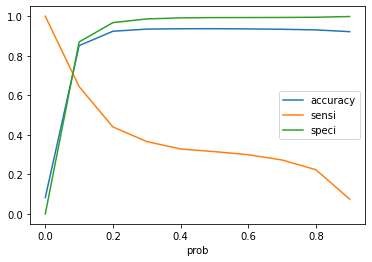

In [793]:
# Let's plot accuracy sensitivity and specificity for various probabilities.
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()
# from the graph 0.1 is the cutoff

In [794]:
y_train_pred_final['final_predicted'] = y_train_pred_final.Churn_Prob.map( lambda x: 1 if x > 0.1 else 0)

y_train_pred_final.head()

,Churn,Churn_Prob,id,predicted,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,final_predicted
9575,0.0,0.056631,9575,0,1,0,0,0,0,0,0,0,0,0,0
33941,0.0,0.053392,33941,0,1,0,0,0,0,0,0,0,0,0,0
13296,0.0,0.173584,13296,0,1,1,0,0,0,0,0,0,0,0,1
21440,0.0,0.004083,21440,0,1,0,0,0,0,0,0,0,0,0,0
4913,0.0,0.448507,4913,0,1,1,1,1,1,0,0,0,0,0,1


In [795]:
confusion_final = print_confusion_matrix_accuracy(y_train_pred_final)
print_other_metrics(confusion_final)

confusion matrix
[[23900   164]
 [ 1491   686]]
Accuracy
0.9369307572119965
Sensitivity is
0.31511254019292606
Specificity is
0.9931848404255319
False Positive Rate is
0.006815159574468085
Positive Predictive value is
0.8070588235294117
Negative Predictive value is
0.9412784057343153


Prediction on test data

In [797]:
X_test = X_test[col]
X_test_sm = sm.add_constant(X_test)

# Predict on test data

y_test_pred = logm3.predict(X_test_sm)
y_test_pred_final = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final['predicted'] = y_test_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)
y_test_pred_final.head()

,Churn,Churn_Prob,predicted
34206,0.0,0.048765,0
13280,0.0,0.073232,0
33506,0.0,0.057252,0
390,0.0,0.025569,0
15461,1.0,0.962979,1


In [798]:
confusion_test = print_confusion_matrix_accuracy(y_test_pred_final)
print_other_metrics(confusion_test)

confusion matrix
[[5276  750]
 [ 201  334]]
Accuracy
0.8550525834476452
Sensitivity is
0.6242990654205608
Specificity is
0.8755393295718553
False Positive Rate is
0.12446067042814471
Positive Predictive value is
0.3081180811808118
Negative Predictive value is
0.9633010772320614


In [799]:
# Top 10 predictors

abs(logm3.params).sort_values(ascending=False)[0:11]

const                    3.123731
churn_indicator          0.691962
total_data_rech_amt_8    0.615394
aon                      0.397221
loc_ic_t2m_mou_7         0.323906
aug_vbc_3g               0.276154
std_og_mou_6             0.213047
loc_ic_t2f_mou_6         0.210992
roam_ic_mou_7            0.205796
jul_vbc_3g               0.202387
last_day_rch_amt_7       0.175435
dtype: float64